In [443]:
import pandas as pd
import numpy as np
import time

import urllib
from urllib.parse import urlparse
import httplib2 as http
import json
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('darkgrid')
%matplotlib inline

%load_ext autoreload
%autoreload 2

from my_functions import Distance_Data
from my_functions import Evaluate
from my_functions import Model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import accuracy_score, balanced_accuracy_score

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction
This python notebook

# McDonald's in Singapore

## McDonald's Price Data
I extracted the prices for 128 food items from the McDonald's app on March 4, 2023 manually for all 144 McDonald's [in-app](https://mcdonalds.com.sg/locate-us).
- I noticed five distinct types of restaurant menu prices in Singapore (i.e if you belong in Category A, all your menu prices are the same), including three Schools (SP, TP and NTU) and four Tourist (Resorts World, Gardens by the Bay, LIDO and Lucky Plaza) locations. 
- We will  explore the distribution of the remaining three categories (A, B, and C) in a later section. 
- Out of 148 clickable restaurants [in-app](https://mcdonalds.com.sg/locate-us), three cannot be selected for ordering, so the I couldn't conclusively state the actual prices from these McDonald's. 

In this section we will explore how to label the non-school and tourist restaurants.

In [570]:
prices = pd.read_excel('data/mcdonalds_prices.xlsx')
prices.head()

,Total,Menu Item,School,A,B,C,Tourist
0,Upsized Meal,Triple Cheeseburger,8.90,9.60,9.60,9.80,10.00
1,Upsized Meal,Double Quarter Pounder¬Æ with Cheese,9.90,10.70,10.95,10.75,10.95
2,Upsized Meal,Quarter Pounder¬Æ with Cheese,8.30,9.10,9.35,9.15,9.35
3,Upsized Meal,Big Mac¬Æ,8.60,9.40,9.65,9.45,9.65
4,Upsized Meal,Double Cheeseburger,7.30,8.00,8.00,8.20,8.40


In [588]:
# create a new dataframe with the minimum value in each row
min_prices = pd.DataFrame({'min_value': prices[['School', 'A', 'B', 'C', 'Tourist']].min(axis=1)})

# create a list of dictionaries, where each dictionary contains the categories with the minimum value for each row
min_categories = []
for i, row in prices.iterrows():
    min_row = row[['School', 'A', 'B', 'C', 'Tourist']] == row[['School', 'A', 'B', 'C', 'Tourist']].min()
    min_cats = list(min_row[min_row == True].index)
    min_categories.append({'min_categories': min_cats})

# combine the minimum value dataframe and the minimum categories list of dictionaries into a single dataframe
min_prices = pd.concat([min_prices, pd.DataFrame(min_categories)], axis=1)

# count the number of times each category appears as a minimum value
counters = {}
for col in ['School', 'A', 'B', 'C', 'Tourist']:
    counters[col] = min_prices[min_prices['min_categories'].apply(lambda x: col in x)].shape[0]

# print out the counters
print(counters)

{'School': 100, 'A': 26, 'B': 27, 'C': 19, 'Tourist': 0}


In [589]:
# create a new dataframe with the maximum value in each row
max_prices = pd.DataFrame({'max_value': prices[['School', 'A', 'B', 'C', 'Tourist']].max(axis=1)})

# create a list of dictionaries, where each dictionary contains the categories with the maximum value for each row
max_categories = []
for i, row in prices.iterrows():
    max_row = row[['School', 'A', 'B', 'C', 'Tourist']] == row[['School', 'A', 'B', 'C', 'Tourist']].max()
    max_cats = list(max_row[max_row == True].index)
    max_categories.append({'max_categories': max_cats})

# combine the maximum value dataframe and the maximum categories list of dictionaries into a single dataframe
max_prices = pd.concat([max_prices, pd.DataFrame(max_categories)], axis=1)

# count the number of times each category appears as a maximum value
counters = {}
for col in ['School', 'A', 'B', 'C', 'Tourist']:
    counters[col] = max_prices[max_prices['max_categories'].apply(lambda x: col in x)].shape[0]

# print out the counters
print(counters)

{'School': 4, 'A': 23, 'B': 46, 'C': 40, 'Tourist': 82}


Since there's no point classifying a "School" or "Tourist", we'll drop them and rerun the min and max values between A, B and C. Schools are obviously the cheapest for most items and Tourist are the most expensive for most items

In [590]:
# create a new dataframe with the minimum value in each row
min_prices = pd.DataFrame({'min_value': prices[['A', 'B', 'C']].min(axis=1)})

# create a list of dictionaries, where each dictionary contains the categories with the minimum value for each row
min_categories = []
for i, row in prices.iterrows():
    min_row = row[['A', 'B', 'C']] == row[['A', 'B', 'C']].min()
    min_cats = list(min_row[min_row == True].index)
    min_categories.append({'min_categories': min_cats})

# combine the minimum value dataframe and the minimum categories list of dictionaries into a single dataframe
min_prices = pd.concat([min_prices, pd.DataFrame(min_categories)], axis=1)

# count the number of times each category appears as a minimum value
counters = {}
for col in ['A', 'B', 'C']:
    counters[col] = min_prices[min_prices['min_categories'].apply(lambda x: col in x)].shape[0]

# print out the counters
print(counters)

{'A': 113, 'B': 65, 'C': 39}


In [591]:
# create a new dataframe with the maximum value in each row
max_prices = pd.DataFrame({'max_value': prices[[ 'A', 'B', 'C']].max(axis=1)})

# create a list of dictionaries, where each dictionary contains the categories with the maximum value for each row
max_categories = []
for i, row in prices.iterrows():
    max_row = row[[ 'A', 'B', 'C']] == row[[ 'A', 'B', 'C']].max()
    max_cats = list(max_row[max_row == True].index)
    max_categories.append({'max_categories': max_cats})

# combine the maximum value dataframe and the maximum categories list of dictionaries into a single dataframe
max_prices = pd.concat([max_prices, pd.DataFrame(max_categories)], axis=1)

# count the number of times each category appears as a maximum value
counters = {}
for col in [ 'A', 'B', 'C']:
    counters[col] = max_prices[max_prices['max_categories'].apply(lambda x: col in x)].shape[0]

# print out the counters
print(counters)

{'A': 35, 'B': 72, 'C': 97}


Here we can clearly see that A sells the most number of cheap items, C sells the most number of expensive items and B is somewhere in between.

In [599]:
# double check the total menu price of A, B and C
print(f"the total menu price of A is {prices['A'].sum():.2f}")
print(f"the total menu price of B is {prices['B'].sum():.2f}")
print(f"the total menu price of C is {prices['C'].sum():.2f}")

# double check the mean price of A, B and C
print(f"the mean price of A is {prices['A'].mean():.2f}")
print(f"the mean price of B is {prices['B'].mean():.2f}")
print(f"the mean price of C is {prices['C'].mean():.2f}")

# double check the median price of A,B and C
print(f"the median price of A is {prices['A'].median():.2f}")
print(f"the median price of B is {prices['B'].median():.2f}")
print(f"the median price of C is {prices['C'].median():.2f}")

the total menu price of A is 777.10
the total menu price of B is 790.80
the total menu price of C is 792.95
the mean price of A is 6.07
the mean price of B is 6.18
the mean price of C is 6.19
the median price of A is 6.10
the median price of B is 6.15
the median price of C is 6.18


In [600]:
# Just to double confirm the labels, we will print the statistics for School and Tourist too
print(f"the total menu price of School is {prices['School'].sum():.2f}")
print(f"the total menu price of Tourist is {prices['Tourist'].sum():.2f}")
print(f"the mean price of School is {prices['School'].mean():.2f}")
print(f"the mean price of Tourist is {prices['Tourist'].mean():.2f}")
print(f"the median price of School is {prices['School'].median():.2f}")
print(f"the median price of Tourist is {prices['Tourist'].median():.2f}")

the total menu price of School is 574.40
the total menu price of Tourist is 660.25
the mean price of School is 5.47
the mean price of Tourist is 6.29
the median price of School is 5.40
the median price of Tourist is 6.15


In [615]:
print(f"the largest average percentage difference between the categories is {(prices['Tourist'].mean() / prices['School'].mean())*100-100:.2f} %")

the largest average percentage difference between the categories is 14.95 %


### Conclusion for McDonald's Price Data
- We will be taking a deeper look at the price differences between the menus and the food categories including the various locations [here](tableau link) 
- There is some discrepancy in total price as Schools and Tourist locations don't sell every single menu item but the mean and median tell the real story. You may check the xlsx file for your own curiosity or visit the tableau dashboard [here](tableau link)
- For now we will tentatively name A: Low, B: Medium, C:High

## McDonald's Geographic Data

- In order to get the latitude and longitude of all the McDonald's in Singapore, I used [Octoparse](https://www.octoparse.com) to scrape google maps.

In [617]:
# import octoparse excel data
octoparse = pd.read_excel('data/McDonaldsOctoparse.xlsx')

octoparse.head()

,24 Hours?,Category,Title,Reviews,Total_Rating,Address,Open_Time,Detail_URL,Google_id,Place_id,Additional_info,Latitude,Longitude,Latitude_backup,Longitude_backup,Category.1,Main_image,Image_1,Image_2,Image_3,Description,Price_Range,Current_Status,Plus_code_URL,Plus_code,Delivery,Open_Time_1,Open_Time_2,Open_Time_3,Open_Time_4,Open_Time_5,Open_Time_6,Open_Time_7,Popular_times_0,Popular_times_1,Popular_times_2,Popular_times_3,Popular_times_4,Popular_times_5,Popular_times_6
0,No,Medium,McDonald's Tampines East Community Club,344.00,4.00,"10 Tampines St 23, #01-01 Tampines East Commun...",2023-03-04 Saturday 7 AM–2 AM\n2023-03-05 Sund...,https://www.google.com/maps/place/McDonald's+T...,0x31da3d1b59902797:0x821904bb4d4417b,ChIJlyeQWRs92jERe0HUtEuQIQg,NaN,1.35,103.95,1.35,103.94,Hamburger restaurant,https://lh5.googleusercontent.com/p/AF1QipMmew...,https://lh5.googleusercontent.com/p/AF1QipMmew...,https://lh5.googleusercontent.com/p/AF1QipPq8r...,https://lh5.googleusercontent.com/p/AF1QipOnLh...,"Classic, long-running fast-food chain known fo...",$,NaN,https://plus.codes/9X33+9R Singapore,9X33+9R Singapore,No-contact delivery,2023-03-04 Saturday 7 AM–2 AM,2023-03-05 Sunday 7 AM–2 AM,2023-03-06 Monday 7 AM–2 AM,2023-03-07 Tuesday 7 AM–2 AM,2023-03-08 Wednesday 7 AM–2 AM,2023-03-09 Thursday 7 AM–2 AM,2023-03-10 Friday 7 AM–2 AM,0% 6 AM13% 7 AM24% 8 AM37% 9 AM48% 10 AM55% 11...,0% 6 AM7% 7 AM14% 8 AM21% 9 AM27% 10 AM29% 11 ...,0% 6 AM5% 7 AM10% 8 AM15% 9 AM19% 10 AM21% 11 ...,0% 6 AM15% 7 AM22% 8 AM22% 9 AM18% 10 AM16% 11...,0% 6 AM9% 7 AM17% 8 AM24% 9 AM29% 10 AM29% 11 ...,0% 6 AM5% 7 AM10% 8 AM17% 9 AM22% 10 AM27% 11 ...,0% 6 AM14% 7 AM25% 8 AM37% 9 AM47% 10 AM53% 11...
1,No,Medium,McDonald's Tampines Mall,1800.00,4.20,"4 Tampines Central 5, #01 - 33 Tampines Mall, ...",2023-03-04 Saturday 7 AM–2 AM\n2023-03-05 Sund...,https://www.google.com/maps/place/McDonald's+T...,0x31da3d1196829a59:0xff6a944953259d47,ChIJWZqClhE92jERR50lU0mUav8,NaN,1.35,103.94,1.35,103.94,Fast food restaurant,https://lh5.googleusercontent.com/p/AF1QipMw-s...,https://lh5.googleusercontent.com/p/AF1QipMwgl...,https://lh5.googleusercontent.com/p/AF1QipOMRF...,https://lh5.googleusercontent.com/p/AF1QipM8v7...,"Classic, long-running fast-food chain known fo...",$,NaN,https://plus.codes/9W3V+3X Singapore,9W3V+3X Singapore,Delivery,2023-03-04 Saturday 7 AM–2 AM,2023-03-05 Sunday 7 AM–12 AM,2023-03-06 Monday 7 AM–12 AM,2023-03-07 Tuesday 7 AM–12 AM,2023-03-08 Wednesday 7 AM–12 AM,2023-03-09 Thursday 7 AM–12 AM,2023-03-10 Friday 7 AM–2 AM,0% 6 AM11% 7 AM24% 8 AM41% 9 AM58% 10 AM70% 11...,0% 6 AM15% 7 AM29% 8 AM41% 9 AM46% 10 AM49% 11...,0% 6 AM9% 7 AM16% 8 AM26% 9 AM36% 10 AM47% 11 ...,0% 6 AM13% 7 AM24% 8 AM34% 9 AM40% 10 AM44% 11...,0% 6 AM12% 7 AM23% 8 AM35% 9 AM44% 10 AM52% 11...,0% 6 AM10% 7 AM22% 8 AM35% 9 AM44% 10 AM50% 11...,0% 6 AM11% 7 AM29% 8 AM51% 9 AM68% 10 AM75% 11...
2,Yes,Medium,McDonald's Tampines West CC,1051.00,4.00,"5 Tampines Ave 3, #01-01 Tampines West Communi...",2023-03-04 Saturday Open 24 hours\n2023-03-05 ...,https://www.google.com/maps/place/McDonald's+T...,0x31da3d6b6f6fc17d:0xc0793b046636f1a1,ChIJfcFvb2s92jERofE2ZgQ7ecA,NaN,1.35,103.94,1.35,103.94,Fast food restaurant,https://lh5.googleusercontent.com/p/AF1QipOc3y...,https://lh5.googleusercontent.com/p/AF1QipOc3y...,https://lh5.googleusercontent.com/p/AF1QipOhE9...,https://lh5.googleusercontent.com/p/AF1QipOrvw...,"Classic, long-running fast-food chain known fo...",$,NaN,https://plus.codes/8WXP+G8 Singapore,8WXP+G8 Singapore,No-contact delivery,2023-03-04 Saturday Open 24 hours,2023-03-05 Sunday Open 24 hours,2023-03-06 Monday Open 24 hours,2023-03-07 Tuesday Open 24 hours,2023-03-08 Wednesday Open 24 hours,2023-03-09 Thursday Open 24 hours,2023-03-10 Friday Open 24 hours,1% 4 AM6% 5 AM14% 6 AM25% 7 AM37% 8 AM49% 9 AM...,1% 4 AM1% 5 AM3% 6 AM12% 7 AM22% 8 AM31% 9 AM3...,1% 4 AM1% 5 AM6% 6 AM14% 7 AM20% 8 AM24% 9 AM2...,1% 4 AM1% 5 AM0% 6 AM8% 7 AM17% 8 AM25% 9 AM29...,1% 4 AM1% 5 AM0% 6 AM8

In [530]:
# plot Latitude and Longitude of all the mcdonalds in Singapore to do a visual check
fig = px.scatter_mapbox(octoparse, lat="Latitude", lon="Longitude", hover_name="Title")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(height=600, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Conclusion for McDonald's Geographic Data:
- **"24 Hours?" is a new feature created in excel using an if else statement based on whether the term "24" appears in Open_Time.** It is a rough approximation of whether the McDonalds is running 24 hours which might affect its prices. 
    - Some of the McDonalds are listed in Google as 24 hours on certain days only or all days. This can be possibly be optimized if deemed worth later on
- **We finalized on working on 144 McDonalds in Singapore.** I compared all 144 McDonalds to the locations scraped from Octoparse and realized that there were actually 148 McDonalds [in-app](https://mcdonalds.com.sg/locate-us). Out of these 4 discrepancies: 
    - 1: McDonalds Tampines (Kiosk) is unscrapable from Google maps
    - 3: McDonalds Changi Airport T4, Choa Chu Kang Park, Choa Chu Kang (Kiosk) can't be selected for ordering hence I can't conclusively state the actual prices from these McDonalds
    - Some of the names in Google Maps scraped from Octoparse are not same in-app, so I manually renamed the McDonald's after double checking the address

### Inconsequential exploration

In [531]:
# Not useful information but it could have been useful if cleaned properly as the delivery / drive-thru feature could affect prices
octoparse.Delivery.value_counts()

Delivery               80
No-contact delivery    54
Takeout                 5
Dine-in                 3
Drive-through           1
Name: Delivery, dtype: int64

In [534]:
octoparse[octoparse.Delivery=='Takeout']

,region,24 Hours?,Category,Title,Reviews,Total_Rating,Address,Open_Time,Detail_URL,Google_id,Place_id,Additional_info,Latitude,Longitude,Latitude_backup,Longitude_backup,Category.1,Main_image,Image_1,Image_2,Image_3,Description,Price_Range,Current_Status,Plus_code_URL,Plus_code,Delivery,Open_Time_1,Open_Time_2,Open_Time_3,Open_Time_4,Open_Time_5,Open_Time_6,Open_Time_7,Popular_times_0,Popular_times_1,Popular_times_2,Popular_times_3,Popular_times_4,Popular_times_5,Popular_times_6
6,East,Yes,Medium,McDonald's Bedok North,1121.00,4.10,"539 Bedok North Street 3, #01-643 Kaki Bukit M...",2023-03-04 Saturday Open 24 hours\n2023-03-05 ...,https://www.google.com/maps/place/McDonald's+B...,0x31da3d51fab21469:0xb2c6145b00298f81,ChIJaRSy-lE92jERgY8pAFsUxrI,NaN,1.33,103.93,1.35,103.94,Hamburger restaurant,https://lh5.googleusercontent.com/p/AF1QipNnN8...,https://lh5.googleusercontent.com/p/AF1QipMrhc...,https://lh5.googleusercontent.com/p/AF1QipMd8r...,https://lh5.googleusercontent.com/p/AF1QipOpZ3...,"Classic, long-running fast-food chain known fo...",$,NaN,https://plus.codes/8WJG+R8 Singapore,8WJG+R8 Singapore,Takeout,2023-03-04 Saturday Open 24 hours,2023-03-05 Sunday 12–2 AM,2023-03-06 Monday 6 AM–2 AM,2023-03-07 Tuesday 6 AM–2 AM,2023-03-08 Wednesday 6 AM–2 AM,2023-03-09 Thursday 6 AM–12 AM,2023-03-10 Friday Open 24 hours,0% 5 AM6% 6 AM20% 7 AM41% 8 AM62% 9 AM76% 10 A...,0% 5 AM3% 6 AM11% 7 AM23% 8 AM36% 9 AM49% 10 A...,0% 5 AM1% 6 AM10% 7 AM22% 8 AM34% 9 AM40% 10 A...,0% 5 AM5% 6 AM11% 7 AM18% 8 AM24% 9 AM28% 10 A...,0% 5 AM3% 6 AM9% 7 AM16% 8 AM24% 9 AM31% 10 AM...,38% 12 AM24% 1 AM12% 2 AM4% 3 AM1% 4 AM1% 5 AM...,56% 12 AM32% 1 AM12% 2 AM1% 3 AM8% 4 AM8% 5 AM...
19,East,No,High,McDonald's T3 Arrival Hall,1851.00,4.20,"65 Airport Blvd., #01-03, Singapore 819653",2023-03-04 Saturday 7 AM–11 PM\n2023-03-05 Sun...,https://www.google.com/maps/place/McDonald's+@...,0x31da3dda5af22c7f:0x5bf964fac3ba5127,ChIJfyzyWto92jERJ1G6w_pk-Vs,NaN,1.36,103.99,1.35,103.94,Hamburger restaurant,https://lh5.googleusercontent.com/p/AF1QipO9TY...,https://lh5.googleusercontent.com/p/AF1QipMusQ...,https://lh5.googleusercontent.com/p/AF1QipPd6s...,https://lh5.googleusercontent.com/p/AF1QipOTYX...,"Classic, long-running fast-food chain known fo...",$,NaN,https://plus.codes/9X4P+MH Singapore,9X4P+MH Singapore,Takeout,2023-03-04 Saturday 7 AM–11 PM,2023-03-05 Sunday 7 AM–11 PM,2023-03-06 Monday 7 AM–11 PM,2023-03-07 Tuesday 7 AM–11 PM,2023-03-08 Wednesday 7 AM–11 PM,2023-03-09 Thursday 7 AM–11 PM,2023-03-10 Friday 7 AM–11 PM,0% 6 AM23% 7 AM32% 8 AM42% 9 AM50% 10 AM57% 11...,0% 6 AM15% 7 AM22% 8 AM29% 9 AM37% 10 AM42% 11...,0% 6 AM19% 7 AM25% 8 AM30% 9 AM34% 10 AM37% 11...,0% 6 AM15% 7 AM22% 8 AM29% 9 AM36% 10 AM41% 11...,0% 6 AM13% 7 AM17% 8 AM23% 9 AM28% 10 AM33% 11...,0% 6 AM26% 7 AM37% 8 AM39% 9 AM33% 10 AM30% 11...,0% 6 AM15% 7 AM24% 8 AM35% 9 AM46% 10 AM53% 11...
46,Central,No,Low,McDonald's Toa Payoh HDB Center,363.00,3.80,"490 Lor 6 Toa Payoh, #01-11 HDB Hub, Singapore...",2023-03-04 Saturday 6 AM–12 AM\n2023-03-05 Sun...,https://www.google.com/maps/place/McDonald's+T...,0x31da176724131837:0x6f2348084b07992,ChIJNxgTJGcX2jERknmwhIA08gY,NaN,1.33,103.85,1.35,103.94,Fast food restaurant,https://lh5.googleusercontent.com/p/AF1QipM9MZ...,https://lh5.googleusercontent.com/p/AF1QipO3nP...,https://lh5.googleusercontent.com/p/AF1QipMBD8...,https://lh5.googleusercontent.com/p/AF1QipNt9F...,"Classic, long-running fast-food chain known fo...",$,NaN,https://plus.codes/8RMX+27 Singapore,8RMX+27 Singapore,Takeout,2023-03-04 Saturday 6 AM–12 AM,2023-03-05 Sunday 6 AM–12 AM,2023-03-06 Monday 6 AM–12 AM,2023-03-07 Tuesday 6 AM–12 AM,2023-03-08 Wednesday 6 AM–12 AM,2023-03-09 Thursday 6 AM–12 AM,2023-03-10 Friday 6 AM–12 AM,0% 5 AM7% 6 AM9% 7 AM14% 8 AM21% 9 AM29% 10 AM...,0% 5 AM24% 6 AM31% 7 AM36% 8 AM39% 9 AM41% 10 ...,0% 5 AM0% 6 AM7% 7 AM31% 8 AM46% 9 AM43% 10 AM...,0% 5 AM12% 6 AM24% 7 AM41% 8 AM56% 9 AM63% 10 ...,0% 5 AM7% 6 AM29% 7 AM58% 8 AM68% 9 AM53% 10 A...,0% 5 

In [535]:
octoparse[octoparse.Delivery=='Dine-in']

,region,24 Hours?,Category,Title,Reviews,Total_Rating,Address,Open_Time,Detail_URL,Google_id,Place_id,Additional_info,Latitude,Longitude,Latitude_backup,Longitude_backup,Category.1,Main_image,Image_1,Image_2,Image_3,Description,Price_Range,Current_Status,Plus_code_URL,Plus_code,Delivery,Open_Time_1,Open_Time_2,Open_Time_3,Open_Time_4,Open_Time_5,Open_Time_6,Open_Time_7,Popular_times_0,Popular_times_1,Popular_times_2,Popular_times_3,Popular_times_4,Popular_times_5,Popular_times_6
24,East,No,High,McDonald’s Jewel,20.00,3.60,"78 Airport Boulevard Jewel, B1-298 Singapore C...",2023-03-04 Saturday 7 AM–11 PM\n2023-03-05 Sun...,https://www.google.com/maps/place/McDonald’s+J...,0x31da3daea16082ad:0x8453916c9a9486b1,ChIJrYJgoa492jERsYaUmmyRU4Q,NaN,1.36,103.99,1.35,103.94,Fast food restaurant,https://lh5.googleusercontent.com/p/AF1QipNNxi...,https://lh5.googleusercontent.com/p/AF1QipNNxi...,https://lh5.googleusercontent.com/p/AF1QipMByb...,https://lh5.googleusercontent.com/p/AF1QipPmsv...,"Classic, long-running fast-food chain known fo...",$,NaN,https://plus.codes/9X6Q+5V Singapore,9X6Q+5V Singapore,Dine-in,2023-03-04 Saturday 7 AM–11 PM,2023-03-05 Sunday 7 AM–11 PM,2023-03-06 Monday 7 AM–11 PM,2023-03-07 Tuesday 7 AM–11 PM,2023-03-08 Wednesday 7 AM–11 PM,2023-03-09 Thursday 7 AM–11 PM,2023-03-10 Friday 7 AM–11 PM,0% 6 AM16% 7 AM29% 8 AM43% 9 AM56% 10 AM68% 11...,0% 6 AM11% 7 AM37% 8 AM65% 9 AM86% 10 AM89% 11...,0% 6 AM1% 7 AM11% 8 AM26% 9 AM43% 10 AM56% 11 ...,0% 6 AM10% 7 AM26% 8 AM46% 9 AM64% 10 AM77% 11...,0% 6 AM5% 7 AM20% 8 AM37% 9 AM52% 10 AM59% 11 ...,0% 6 AM13% 7 AM35% 8 AM50% 9 AM53% 10 AM44% 11...,0% 6 AM28% 7 AM41% 8 AM53% 9 AM65% 10 AM73% 11...
45,East,No,High,McDonald's Changi Airport T2 Transit Lounge,140.00,4.00,Changi Airport Terminal 2 Departure/ Transit L...,2023-03-04 Saturday 7 AM–11 PM\n2023-03-05 Sun...,https://www.google.com/maps/place/McDonald's+C...,0x31da3d856ebe62c1:0x46ded1e7969d7d5b,ChIJwWK-boU92jERW32dlufR3kY,NaN,1.36,103.99,1.35,103.94,Hamburger restaurant,https://lh5.googleusercontent.com/p/AF1QipNk81...,https://lh5.googleusercontent.com/p/AF1QipN1Gj...,https://lh5.googleusercontent.com/p/AF1QipOPM6...,https://lh5.googleusercontent.com/p/AF1QipNt6c...,"Classic, long-running fast-food chain known fo...",$,NaN,https://plus.codes/9X4Q+48 Singapore,9X4Q+48 Singapore,Dine-in,2023-03-04 Saturday 7 AM–11 PM,2023-03-05 Sunday 7 AM–11 PM,2023-03-06 Monday 7 AM–11 PM,2023-03-07 Tuesday 7 AM–11 PM,2023-03-08 Wednesday 7 AM–11 PM,2023-03-09 Thursday 7 AM–11 PM,2023-03-10 Friday 7 AM–11 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,North,No,Medium,McDonald’s Admiralty Place,34.00,2.30,"678A Woodlands Ave 6, #01-05, Singapore 731678",2023-03-05 Sunday 6 AM–11 PM\n2023-03-06 Monda...,https://www.google.com/maps/place/McDonald’s+A...,0x31da1369e3b94b29:0xe49c31d3ed6a2fcd,ChIJKUu542kT2jERzS9q7dMxnOQ,NaN,1.44,103.80,1.44,103.80,Fast food restaurant,https://lh5.googleusercontent.com/p/AF1QipOuxZ...,https://lh5.googleusercontent.com/p/AF1QipOuxZ...,https://lh5.googleusercontent.com/p/AF1QipNbgS...,https://lh5.googleusercontent.com/p/AF1QipMxOE...,NaN,None,NaN,https://plus.codes/CRR2+3C Singapore,CRR2+3C Singapore,Dine-in,2023-03-05 Sunday 6 AM–11 PM,2023-03-06 Monday 6 AM–11 PM,2023-03-07 Tuesday 6 AM–11 PM,2023-03-08 Wednesday 6 AM–11 PM,2023-03-09 Thursday 6 AM–11 PM,2023-03-10 Friday 6 AM–11 PM,2023-03-11 Saturday 6 AM–11 PM,0% 5 AM0% 6 AM0% 7 AM1% 8 AM1% 9 AM20% 10 AM36...,0% 5 AM0% 6 AM0% 7 AM1% 8 AM2% 9 AM17% 10 AM32...,0% 5 AM0% 6 AM0% 7 AM1% 8 AM1% 9 AM1% 10 AM2% ...,0% 5 AM0% 6 AM0% 7 AM1% 8 AM3% 9 AM13% 10 AM13...,0% 5 AM0% 6 AM0% 7 AM1% 8 AM1% 9 AM11% 10 AM25...,0% 5 AM0% 6 AM1% 7 AM1% 8 AM5% 9 AM15% 10 AM17...,0% 5 AM0% 6 AM1% 7 AM1% 8 AM11% 9 AM30% 10 AM4...


## Combining Price and Geography

In [532]:
# building the base mcd_df
mcd_df = octoparse[['Title','Latitude','Longitude','24 Hours?']]

In [616]:
# export mcd_df to csv
mcd_df.to_csv('data/mcd_df.csv', index=False)

From the csv file, I did the other following manual steps (*I know faster ways probably exist but I was just trying to analyse the data as soon as possible and 144 wasn't a large sample*)
- From the app, I labelled classified each of the 144 McDonalds into: School, Low, Medium, High, Tourist (this will be our target y variable) based on the [in-app](https://mcdonalds.com.sg/locate-us) prices
- Using visual inspection of the map, I manually added the [Planning Area](https://www.singstat.gov.sg/-/media/files/publications/population/population2015-map1.ashx) and [Subzone](https://www.singstat.gov.sg/-/media/files/publications/population/population2015-map1.ashx) of each McDonald's because I wanted population and/or density to be part of the features for the model
- I removed the 4 McDonald's the we previously could not get Google Maps data of 

I actually tried fitting some other features manually but these didn't seem to help much so you won't see them, it seemed like the more granular detail obtained from the other features worked better
- the latest [Makan Index](https://lkyspp.nus.edu.sg/ips/research/ips-social-lab/makan-index-2) which you can read more about [here](https://sg.news.yahoo.com/where-cheapest-food-drink-singapore-ips-makan-index-102741769.html)
- region (North, South, East, West etc.)
- region type (OCR, RCR, CCR)

In [714]:
# import mcd_df.csv to mcd_df
mcd_df = pd.read_csv('data/mcd_df.csv')

In [657]:
mcd_df.shape

(144, 7)

In [654]:
mcd_df.head()

,Title,Latitude,Longitude,24 Hours?,planning_area,subzone,classification
0,McDonald's Tampines East Community Club,1.35,103.95,No,Tampines,Tampines East,Medium
1,McDonald's Tampines Mall,1.35,103.94,No,Tampines,Tampines East,Medium
2,McDonald's Tampines West CC,1.35,103.94,Yes,Tampines,Tampines West,Medium
3,McDonald's Bedok Reservoir,1.33,103.91,Yes,Bedok,Kaki Bukit,Low
4,McDonald's Pasir Ris Sports Complex,1.37,103.95,Yes,Pasir Ris,Pasir Ris Central,High


In [628]:
mcd_df.nunique()

Title             144
Latitude          144
Longitude         144
24 Hours?           2
planning_area      38
subzone           112
classification      5
dtype: int64

In [658]:
# do a value count of our target classification
mcd_df['classification'].value_counts()

Medium     77
High       31
Low        29
Tourist     4
Student     3
Name: classification, dtype: int64

In [715]:
# rename columns with lower casing
mcd_df.columns = mcd_df.columns.str.lower()

# rename 24 hours?
mcd_df.rename(columns={'24 hours?':'24_hours'}, inplace=True)

In [649]:
mcd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           144 non-null    object 
 1   latitude        144 non-null    float64
 2   longitude       144 non-null    float64
 3   24_hours        144 non-null    object 
 4   planning_area   144 non-null    object 
 5   subzone         144 non-null    object 
 6   classification  144 non-null    object 
dtypes: float64(2), object(5)
memory usage: 8.0+ KB


In [660]:
# do a map of Singapore using plotly for latitude and longitude with contrasting colours as classification
# get without a df without student or tourist
without = mcd_df[mcd_df['classification']!='Student']
without = without[without['classification']!='Tourist']

fig = px.scatter_mapbox(without, lat="latitude", lon="longitude", color="classification", zoom=10, text = 'title',height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

### Conclusion for Combining Price and Geographic Data
- Most of the mcdonalds that are 'Low' tend to be from the North.
- 'Medium' is the dominant classification
- 'High' is the most dominant near the central region of Singapore
- 'Tourist' and 'Student' are probably not very worth evaluating since it's easy to classify them and the sample size is small

# Getting Additional Data

## LTA Data
Here we try to extract bus stop traffic and the number of bus stops as a feature to predict the different tiered prices of McDonald's.

You can read more about LTA's Datamall API [here](https://datamall.lta.gov.sg/content/dam/datamall/datasets/LTA_DataMall_API_User_Guide.pdf)

### Bus Stop Data

In [386]:
# Create an empty dataframe to store the data
stop_df = pd.DataFrame(columns = ['BusStopCode', 'RoadName', \
                                    'Description', 'Latitude', \
                                    'Longitude'])

In [387]:
# Extracting bus stop data
api_file_path = 'data/api_key.txt'
with open(api_file_path, 'r') as f:
            api_key = f.read().strip()
uri =  'http://datamall2.mytransport.sg/ltaodataservice/'
path = 'BusStops'
headers = { 'AccountKey' : api_key, 'accept' : 'application/json'}
method = 'GET'
h = http.Http()

for i in range(0,5500,500): # There are about 5000+ bus stops currently and they return a limit of 500 at a go
    skip = '?$skip=' + str(i)
    target = urlparse(uri + path + skip)
    print(f'The target url is {target.geturl()}')
    response, content = h.request(target.geturl(),method,'',headers)
    print(response)
    data = json.loads(content)
    df = pd.DataFrame(data['value'])
    stop_df =  pd.concat([stop_df, df], ignore_index=True)

The target url is http://datamall2.mytransport.sg/ltaodataservice/BusStops?$skip=0
{'date': 'Mon, 27 Mar 2023 06:45:55 GMT', 'content-type': 'application/json;charset=UTF-8', 'transfer-encoding': 'chunked', 'connection': 'keep-alive', 'cache-control': 'no-store', 'content-language': 'en-SG', 'status': '200', 'content-location': 'http://datamall2.mytransport.sg/ltaodataservice/BusStops?$skip=0'}
The target url is http://datamall2.mytransport.sg/ltaodataservice/BusStops?$skip=500
{'date': 'Mon, 27 Mar 2023 06:45:55 GMT', 'content-type': 'application/json;charset=UTF-8', 'transfer-encoding': 'chunked', 'connection': 'keep-alive', 'cache-control': 'no-store', 'content-language': 'en-SG', 'status': '200', 'content-location': 'http://datamall2.mytransport.sg/ltaodataservice/BusStops?$skip=500'}
The target url is http://datamall2.mytransport.sg/ltaodataservice/BusStops?$skip=1000
{'date': 'Mon, 27 Mar 2023 06:45:55 GMT', 'content-type': 'application/json;charset=UTF-8', 'transfer-encoding': '

In [388]:
print(f'The dataframe has a shape of {stop_df.shape}')

The dataframe has a shape of (5083, 5)


In [389]:
# explore the data gotten from the API
stop_df.head()

,BusStopCode,RoadName,Description,Latitude,Longitude
0,01012,Victoria St,Hotel Grand Pacific,1.30,103.85
1,01013,Victoria St,St. Joseph's Ch,1.30,103.85
2,01019,Victoria St,Bras Basah Cplx,1.30,103.85
3,01029,Nth Bridge Rd,Opp Natl Lib,1.30,103.85
4,01039,Nth Bridge Rd,Bugis Cube,1.30,103.86


In [390]:
stop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5083 entries, 0 to 5082
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BusStopCode  5083 non-null   object 
 1   RoadName     5083 non-null   object 
 2   Description  5083 non-null   object 
 3   Latitude     5083 non-null   float64
 4   Longitude    5083 non-null   float64
dtypes: float64(2), object(3)
memory usage: 198.7+ KB


In [391]:
# check for duplicates
stop_df.duplicated().sum()

0

In [392]:
# check for null values
stop_df.isnull().sum()

BusStopCode    0
RoadName       0
Description    0
Latitude       0
Longitude      0
dtype: int64

In [393]:
# check for unique values
stop_df.nunique()

BusStopCode    5083
RoadName        838
Description    4542
Latitude       5083
Longitude      5082
dtype: int64

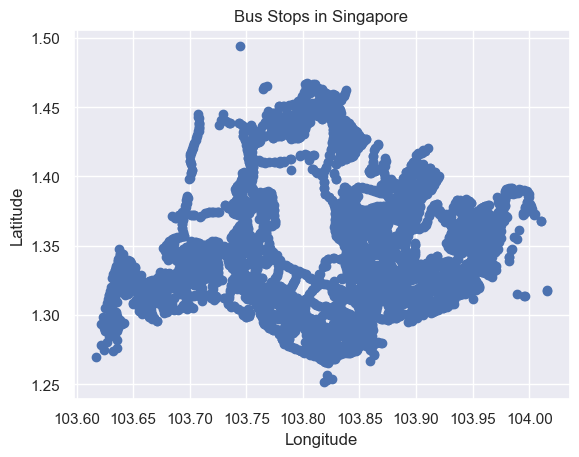

In [394]:
# plot latitude and longitude on a scatter plot to visualize
plt.scatter(stop_df['Longitude'],stop_df['Latitude'])
plt.title('Bus Stops in Singapore')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [395]:
# always export the data to a file locally if possible in case the kernel crashes

# file name
csv_file_name = 'data/bus_stops.csv'

# export data to csv
stop_df.to_csv(csv_file_name)

### Bus Traffic Data

In [396]:
# Extracting bus stop data
api_file_path = 'data/api_key.txt'
with open(api_file_path, 'r') as f:
            api_key = f.read().strip()
uri =  'http://datamall2.mytransport.sg/ltaodataservice/'
path = 'PV/Bus'
headers = { 'AccountKey' : api_key, 'accept' : 'application/json'}
method = 'GET'
h = http.Http()

for i in ['202302']: # put the month you want in YYYYMM format, you can only get up to the past 3 months
    skip = '?Date=' + i
    target = urlparse(uri + path + skip)
    print(f'The target url is {target.geturl()}')
    response, content = h.request(target.geturl(),method,'',headers)
    print(response)
    data = json.loads(content)
    print(data['value']) # you will get a link to download a csv file

The target url is http://datamall2.mytransport.sg/ltaodataservice/PV/Bus?Date=202302
{'date': 'Mon, 27 Mar 2023 06:45:56 GMT', 'content-type': 'application/json;charset=UTF-8', 'transfer-encoding': 'chunked', 'connection': 'keep-alive', 'cache-control': 'no-store', 'content-language': 'en-US', 'status': '200', 'content-location': 'http://datamall2.mytransport.sg/ltaodataservice/PV/Bus?Date=202302'}
[{'Link': 'https://ltafarecard.s3.ap-southeast-1.amazonaws.com/202302/transport_node_bus_202302.zip?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEE8aDmFwLXNvdXRoZWFzdC0xIkcwRQIhALEzNu96Rfe%2BhCHUbY2LkUUjgbTgAi0t1%2FbzytW5qF9YAiBWHfCl6P5lZCj8GVMC9BK2lRcVzAogd9ogMxX9PDScjCrCBQgoEAMaDDM0MDY0NTM4MTMwNCIMIveTI21v9PMVvto1Kp8FZWrfQ%2FxI%2Fcrozoiok%2FHjl99csy6Q7i8p53nGZqKWTBsMLcqL7a2elNfb63wuVlWhEXhU%2BWy2SIGbXcmyMSv8WhFp9a%2FMjGfwDwdUYCWyoMdoKKX3Stcgub0QkP%2Bkwau8RXJJuWueshvGSDobIXjgK5F3cVBEKfE9UXBrDFq6ZB1zkfYQqB08DKtTZqZkNr19aaYG5UfFNq1bKvVbyVY6f3HRPBnXpmMKhtVJL%2ByM4Zkv7AbUuymohKWeHUdsIf%2BFMyIaRUQU%2B3e

In [397]:
# import all the csvs and concat them, we managed to get 2022 November to 2023 February
df = pd.read_csv('data/transport_node_bus_202211.csv')
df1 = pd.read_csv('data/transport_node_bus_202212.csv')
df2 = pd.read_csv('data/transport_node_bus_202301.csv')
df3 = pd.read_csv('data/transport_node_bus_202302.csv')

traffic_df = pd.concat([df,df1,df2,df3], ignore_index=True)

In [398]:
print(f'The dataframe has a shape of {traffic_df.shape}')

The dataframe has a shape of (785988, 7)


In [399]:
# explore the data gotten from the API
traffic_df.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,2022-11,WEEKDAY,17,BUS,45379,375,368
1,2022-11,WEEKENDS/HOLIDAY,17,BUS,45379,142,102
2,2022-11,WEEKENDS/HOLIDAY,13,BUS,80051,965,902
3,2022-11,WEEKDAY,13,BUS,80051,2329,2319
4,2022-11,WEEKENDS/HOLIDAY,8,BUS,3511,50,133


In [400]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785988 entries, 0 to 785987
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   YEAR_MONTH            785988 non-null  object
 1   DAY_TYPE              785988 non-null  object
 2   TIME_PER_HOUR         785988 non-null  int64 
 3   PT_TYPE               785988 non-null  object
 4   PT_CODE               785988 non-null  int64 
 5   TOTAL_TAP_IN_VOLUME   785988 non-null  int64 
 6   TOTAL_TAP_OUT_VOLUME  785988 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 42.0+ MB


In [401]:
# check for duplicates
traffic_df.duplicated().sum()

0

In [402]:
# check for null values
traffic_df.isnull().sum()

YEAR_MONTH              0
DAY_TYPE                0
TIME_PER_HOUR           0
PT_TYPE                 0
PT_CODE                 0
TOTAL_TAP_IN_VOLUME     0
TOTAL_TAP_OUT_VOLUME    0
dtype: int64

In [403]:
# check for unique values
traffic_df.nunique()

YEAR_MONTH                 4
DAY_TYPE                   2
TIME_PER_HOUR             24
PT_TYPE                    1
PT_CODE                 5082
TOTAL_TAP_IN_VOLUME     9042
TOTAL_TAP_OUT_VOLUME    9171
dtype: int64

In [404]:
# drop useless columns
traffic_df.drop(columns = ['PT_TYPE'], inplace = True)

In [405]:
# convert column to correct data type
traffic_df['PT_CODE']=traffic_df['PT_CODE'].astype('str')

# for each value in PT_code find out the length
traffic_df['PT_CODE_LEN'] = traffic_df['PT_CODE'].apply(lambda x: len(x))
print(traffic_df['PT_CODE_LEN'].value_counts())

# if length of PT_CODE is 4, add a 0 in front
traffic_df['PT_CODE'] = traffic_df['PT_CODE'].apply(lambda x: '0' + x if len(x) == 4 else x)

traffic_df['PT_CODE_LEN'] = traffic_df['PT_CODE'].apply(lambda x: len(x))
print(traffic_df['PT_CODE_LEN'].value_counts())

# drop the PT_CODE_LEN column
traffic_df.drop('PT_CODE_LEN', axis=1, inplace=True)

print('converted all PT_CODE to 5 digits')

5    750212
4     35776
Name: PT_CODE_LEN, dtype: int64
5    785988
Name: PT_CODE_LEN, dtype: int64
converted all PT_CODE to 5 digits


In [406]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785988 entries, 0 to 785987
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   YEAR_MONTH            785988 non-null  object
 1   DAY_TYPE              785988 non-null  object
 2   TIME_PER_HOUR         785988 non-null  int64 
 3   PT_CODE               785988 non-null  object
 4   TOTAL_TAP_IN_VOLUME   785988 non-null  int64 
 5   TOTAL_TAP_OUT_VOLUME  785988 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 36.0+ MB


In [407]:
traffic_df.describe()

,TIME_PER_HOUR,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
count,785988.00,785988.00,785988.00
mean,13.29,387.32,387.31
std,6.12,1350.92,1295.69
min,0.00,0.00,0.00
25%,9.00,20.00,22.00
50%,14.00,101.00,108.00
75%,18.00,346.00,349.00
max,23.00,113537.00,92366.00


In [408]:
# always export the data to a file locally if possible in case the kernel crashes

# file name
csv_file_name = 'data/traffic_data.csv'

# export data to csv
traffic_df.to_csv(csv_file_name)

## Population Data
We extract Population Data by Subzone and Dwelling Type from [Singstat](https://www.singstat.gov.sg/find-data/search-by-theme/population/geographic-distribution/latest-data) to map it to planning_area and subzone for each McDonald's

In [669]:
# import csv
pop_df = pd.read_csv('data/hsetod2022.csv')
pop_df.head()

,PA,SZ,TOD,Hse,Time
0,Ang Mo Kio,Ang Mo Kio Town Centre,HDB 1- and 2-Room Flats,0,2022
1,Ang Mo Kio,Ang Mo Kio Town Centre,HDB 3-Room Flats,170,2022
2,Ang Mo Kio,Ang Mo Kio Town Centre,HDB 4-Room Flats,220,2022
3,Ang Mo Kio,Ang Mo Kio Town Centre,HDB 5-Room and Executive Flats,580,2022
4,Ang Mo Kio,Ang Mo Kio Town Centre,HUDC Flats (excluding those privatised),0,2022


In [688]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2656 entries, 0 to 2655
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   PA      2656 non-null   object
 1   SZ      2656 non-null   object
 2   TOD     2656 non-null   object
 3   Hse     2656 non-null   int64 
 4   Time    2656 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 103.9+ KB


In [682]:
# We need a dataframe of total population by SZ
sz_pop_df = pop_df.groupby('SZ')['Hse'].sum()
print(sz_pop_df.head())
print()
print(f'there are {len(sz_pop_df)} subzones')

SZ
Admiralty           4670
Airport Road           0
Alexandra Hill      5430
Alexandra North     1870
Aljunied           22590
Name: Hse, dtype: int64

there are 332 subzones


In [683]:
# We need a dataframe of total population by PA
pa_pop_df = pop_df.groupby('PA')['Hse'].sum()
print(pa_pop_df.head())
print()
print(f'there are {len(pa_pop_df)} planning areas')

PA
Ang Mo Kio      62280
Bedok          108700
Bishan          30400
Boon Lay            0
Bukit Batok     59800
Name: Hse, dtype: int64

there are 55 planning areas


In [687]:
print(pop_df.TOD.value_counts())

HDB 1- and 2-Room Flats                    332
HDB 3-Room Flats                           332
HDB 4-Room Flats                           332
HDB 5-Room and Executive Flats             332
HUDC Flats (excluding those privatised)    332
Landed Properties                          332
Condominiums and Other Apartments          332
Others                                     332
Name: TOD, dtype: int64


Here we assume a certain hierarchy of disposable income for McDonald's based on the population dwelling in a particular TOD
- HDB 1-2 room = 1.5 , HDB 3 room = 3, HDB 4 room = 4 etc i.e. someone living in a 4 room flat earns 4/3 times that of someone living in a 3 room flat because that is the house they can afford
- In reality this is a very simple approximation and this probably does not proportionally scale especially when we reach Landed Properties but we can assume it is ordinally correct hence any scale differences can be solved with a scaler during modelling

In [689]:
tod_dict = {'HDB 1- and 2-Room Flat':1.5, 'HDB 3-Room Flats':3, 'HDB 4-Room Flats':4, 'HDB 5-Room and Executive Flats':5, 'HUDC Flats (excluding those privatised)':6, 'Condominiums and Other Apartments':7, 'Landed Properties':8, 'Others':9}

In [700]:
# create a new df called sz_income_df
sz_income_df = pop_df[['SZ','TOD','Hse']].copy()

# We need a an approximation of average residential income by SZ based on tod_dict so we multiply the value of Hse with tod_dict
sz_income_df['pop_income'] = sz_income_df['TOD'].map(tod_dict) * pop_df['Hse']

sz_income_df = sz_income_df.fillna(0)

# for each SZ in sz_income_df, sum up the pop_income and divide it by the number in sz_pop_df for the same SZ
sz_income_df['sz_income'] = sz_income_df.groupby('SZ')['pop_income'].transform('sum')

# groupby SZ and average out the sz_income
sz_income_df = sz_income_df.groupby('SZ')['sz_income'].mean()

sz_income_df.head()

SZ
Admiralty          18900.00
Airport Road           0.00
Alexandra Hill     15330.00
Alexandra North    13090.00
Aljunied          116930.00
Name: sz_income, dtype: float64

In [701]:
# create new df called pa_income_df
pa_income_df = pop_df[['PA','TOD','Hse']].copy()

# We need a an approximation of average residential income by PA based on tod_dict so we multiply the value of Hse with tod_dict
pa_income_df['pop_income'] = pa_income_df['TOD'].map(tod_dict) * pop_df['Hse']

pa_income_df = pa_income_df.fillna(0)

# for each PA in pa_income_df, sum up the pop_income and divide it by the number in pa_pop_df for the same PA
pa_income_df['pa_income'] = pa_income_df.groupby('PA')['pop_income'].transform('sum')

# groupby PA and average out the pa_income
pa_income_df = pa_income_df.groupby('PA')['pa_income'].mean()

pa_income_df.head()

PA
Ang Mo Kio    248520.00
Bedok         548500.00
Bishan        157080.00
Boon Lay           0.00
Bukit Batok   262080.00
Name: pa_income, dtype: float64

In [710]:
# Lastly we create a df of average residential income by SZ and PA by dividing sz_income_df by sz_pop_df by SZ
sz_avg_income_df = sz_income_df / sz_pop_df
pa_avg_income_df = pa_income_df / pa_pop_df

sz_avg_income_df.fillna(0, inplace=True)
pa_avg_income_df.fillna(0, inplace=True)

# convert to dataframe
sz_avg_income_df = pd.DataFrame(sz_avg_income_df)
pa_avg_income_df = pd.DataFrame(pa_avg_income_df)

### Merge with mcd_df

In [716]:
# merge all sz and pa df with mcd_df based on planning_area and subzone
mcd_df = mcd_df.merge(sz_pop_df, how='left', left_on='subzone', right_on='SZ')
mcd_df = mcd_df.merge(pa_pop_df, how='left', left_on='planning_area', right_on='PA')
mcd_df = mcd_df.merge(sz_avg_income_df, how='left', left_on='subzone', right_on='SZ')
mcd_df = mcd_df.merge(pa_avg_income_df, how='left', left_on='planning_area', right_on='PA')
mcd_df = mcd_df.merge(sz_income_df, how='left', left_on='subzone', right_on='SZ')
mcd_df = mcd_df.merge(pa_income_df, how='left', left_on='planning_area', right_on='PA')

In [718]:
# rename columns
mcd_df.rename(columns={'Hse_x':'sz_pop', 'Hse_y':'pa_pop', '0_x':'sz_avg_income', '0_y':'pa_avg_income'}, inplace=True)

In [719]:
mcd_df.head()

,title,latitude,longitude,24_hours,planning_area,subzone,classification,sz_pop,pa_pop,sz_avg_income,pa_avg_income,sz_income,pa_income
0,McDonald's Tampines East Community Club,1.35,103.95,No,Tampines,Tampines East,Medium,41660,90260,4.04,4.45,168300.00,401990.00
1,McDonald's Tampines Mall,1.35,103.94,No,Tampines,Tampines East,Medium,41660,90260,4.04,4.45,168300.00,401990.00
2,McDonald's Tampines West CC,1.35,103.94,Yes,Tampines,Tampines West,Medium,27330,90260,4.51,4.45,123350.00,401990.00
3,McDonald's Bedok Reservoir,1.33,103.91,Yes,Bedok,Kaki Bukit,Low,12330,108700,4.38,5.05,54030.00,548500.00
4,McDonald's Pasir Ris Sports Complex,1.37,103.95,Yes,Pasir Ris,Pasir Ris Central,High,11270,47820,5.47,5.48,61630.00,261930.00


## Hawker Count Data

### Getting latitude and longitude of all hawkers in Singapore
Data retrieved from [data.gov.sg](https://data.gov.sg/dataset/hawker-centres?resource_id=8a6c2f75-5511-4e03-b8f2-23ce67d30b28). Last updated 1 Sep 2021

In [ ]:
# import geojson file
with open('data/hawker-centres-geojson.geojson') as f:
    data = json.load(f)

In [ ]:
h_latitude=[]
h_longitude=[]

for i in range(len(data['features'])):
    h_latitude.append(data['features'][i]['geometry']['coordinates'][1])
    h_longitude.append(data['features'][i]['geometry']['coordinates'][0])

# create a dataframe to store the hawker centre data
hawker_df = pd.DataFrame(columns=['latitude', 'longitude'])
hawker_df['latitude']=h_latitude
hawker_df['longitude']=h_longitude

### Counting the number of hawker centres around each McDonald's

In [724]:
# set a list of distances in km
distance_list = [2,1,0.5,0.2]

In [ ]:
# Get the num_hawker feature data
for i in distance_list:
    print(f'This is the run for distance {i}km')
    
    # this function initiates the dataframe based on the length of mcd_df and then computes the number of X within the distance
    # the columns of the item to be counted must be 'latitude' and 'longitude'
    result = Distance_Data(mcd_df).num_count(i,mcd_df,hawker_df,'hawker_count')

    # save the data to csv
    result.to_csv(f'hawker_{i}.csv', index=False)
    print(f'Successfully finished for distance {i}km')

This is the run for distance 0.2km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 0.2km
This is the run for distance 0.5km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 0.5km
This is the run for distance 1km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 1km
This is the run for distance 2km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 2km


## HDB Count Data

### Getting latitude and longitude of all hdbs in Singapore
Data obtained from [data.gov.sg](https://data.gov.sg/dataset/hdb-property-information). Last updated 4 Jan 2023

In [722]:
# file path
csv = 'data/hdb-property-information.csv'

# import data to csv
hdb_info_df = pd.read_csv(csv)

print(hdb_info_df.head())

  blk_no             street  max_floor_lvl  year_completed residential  \
0      1           BEACH RD             16            1970           Y   
1      1    BEDOK STH AVE 1             14            1975           Y   
2      1      CANTONMENT RD              2            2010           N   
3      1       CHAI CHEE RD             15            1982           Y   
4      1  CHANGI VILLAGE RD              4            1975           Y   

  commercial market_hawker miscellaneous multistorey_carpark  \
0          Y             N             N                   N   
1          N             N             Y                   N   
2          Y             N             N                   N   
3          N             N             N                   N   
4          Y             N             N                   N   

  precinct_pavilion bldg_contract_town  total_dwelling_units  1room_sold  \
0                 N                KWN                   142           0   
1                 

In [ ]:
latitude = []
longitude = []

for i in range(len(hdb_info_df)):
    url = f"https://developers.onemap.sg/commonapi/search?searchVal={hdb_info_df.loc[i,'address']}&returnGeom=Y&getAddrDetails=N&pageNum=1"
    data = requests.get(url).json()
    try:
        latitude.append(data['results'][0]['LATITUDE'])
        longitude.append(data['results'][0]['LONGITUDE'])
    except:
        latitude.append(0)
        longitude.append(0)
    time.sleep(0.15)
    print(f'this is run {i}')

In [ ]:
print(len(latitude))
print(len(longitude))

In [ ]:
# save latitudes and longitudes into hdb_df as 'latitude' and 'longitude'
hdb_info_df['latitude'] = latitude
hdb_info_df['longitude'] = longitude

In [ ]:
# export hdb_df as csv
hdb_info_df.to_csv('data/hdb_df.csv', index=False)

### Counting the number of HDBs around each McDonald's

In [ ]:
# Get the num_hdb feature data
for i in distance_list:
    print(f'This is the run for distance {i}km')
    
    # this function initiates the dataframe based on the length of mcd_df and then computes the number of X within the distance
    # the columns of the item to be counted must be 'latitude' and 'longitude'
    result = Distance_Data(mcd_df).num_count(i,mcd_df,hdb_df,'hdb_count')

    # save the data to csv
    result.to_csv(f'hdb_{i}.csv', index=False)
    print(f'Successfully finished for distance {i}km')

This is the run for distance 0.2km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 0.2km
This is the run for distance 0.5km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 0.5km
This is the run for distance 1km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 1km
This is the run for distance 2km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 2km


# Importing Data

## CSV Files

In [720]:
# file path
csv = 'data/traffic_data.csv'

# import data to csv
traffic_df = pd.read_csv(csv,index_col=0)

# convert column to correct data type
traffic_df['PT_CODE']=traffic_df['PT_CODE'].astype('str')

# for each value in PT_code find out the length
traffic_df['PT_CODE_LEN'] = traffic_df['PT_CODE'].apply(lambda x: len(x))
print(traffic_df['PT_CODE_LEN'].value_counts())

# if length of PT_CODE is 4, add a 0 in front
traffic_df['PT_CODE'] = traffic_df['PT_CODE'].apply(lambda x: '0' + x if len(x) == 4 else x)

traffic_df['PT_CODE_LEN'] = traffic_df['PT_CODE'].apply(lambda x: len(x))
print()
print(traffic_df['PT_CODE_LEN'].value_counts())
print('converted all PT_CODE to 5 digits')

# drop the PT_CODE_LEN column
traffic_df.drop('PT_CODE_LEN', axis=1, inplace=True)

print()
print(traffic_df.head())

5    750212
4     35776
Name: PT_CODE_LEN, dtype: int64

5    785988
Name: PT_CODE_LEN, dtype: int64
converted all PT_CODE to 5 digits

  YEAR_MONTH          DAY_TYPE  TIME_PER_HOUR PT_CODE  TOTAL_TAP_IN_VOLUME  \
0    2022-11           WEEKDAY             17   45379                  375   
1    2022-11  WEEKENDS/HOLIDAY             17   45379                  142   
2    2022-11  WEEKENDS/HOLIDAY             13   80051                  965   
3    2022-11           WEEKDAY             13   80051                 2329   
4    2022-11  WEEKENDS/HOLIDAY              8   03511                   50   

   TOTAL_TAP_OUT_VOLUME  
0                   368  
1                   102  
2                   902  
3                  2319  
4                   133  


In [721]:
# file path
csv = 'data/bus_stops.csv'

# import data to csv
stops_df = pd.read_csv(csv, index_col=0)

# convert column to correct data type
stops_df['BusStopCode']=stops_df['BusStopCode'].astype('str')

# for each value in BusStopCode find out the length
stops_df['BusStopCode_LEN'] = stops_df['BusStopCode'].apply(lambda x: len(x))
print(stops_df['BusStopCode_LEN'].value_counts())

# if length of BusStopCode is 4, add a 0 in front
stops_df['BusStopCode'] = stops_df['BusStopCode'].apply(lambda x: '0' + x if len(x) == 4 else x)

stops_df['BusStopCode_LEN'] = stops_df['BusStopCode'].apply(lambda x: len(x))
print()
print(stops_df['BusStopCode_LEN'].value_counts())
print('converted all BusStopCode to 5 digits')
# drop the BusStopCode_LEN column
stops_df.drop('BusStopCode_LEN', axis=1, inplace=True)

stops_df = stops_df.drop(columns=['RoadName','Description'])
stops_df['BusStopCode']=stops_df['BusStopCode'].astype(str)

pd.set_option('display.float_format', lambda x: '%.5f' % x)
print()
print(stops_df.head())
pd.set_option('display.float_format', lambda x: '%.2f' % x)

5    4851
4     232
Name: BusStopCode_LEN, dtype: int64

5    5083
Name: BusStopCode_LEN, dtype: int64
converted all BusStopCode to 5 digits

  BusStopCode  Latitude  Longitude
0       01012   1.29685  103.85254
1       01013   1.29771  103.85322
2       01019   1.29699  103.85302
3       01029   1.29667  103.85441
4       01039   1.29821  103.85549


In [7]:
# import other data previously feature engineered
hdb_df = pd.read_csv('data/hdb_df.csv')
hawker_df = pd.read_csv('data/hawker_df.csv')

hdb_02 = pd.read_csv('data/hdb_0.2.csv')
hdb_05 = pd.read_csv('data/hdb_0.5.csv')
hdb_1 = pd.read_csv('data/hdb_1.csv')
hdb_2 = pd.read_csv('data/hdb_2.csv')

hawker_02 = pd.read_csv('data/hawker_0.2.csv')
hawker_05 = pd.read_csv('data/hawker_0.5.csv')
hawker_1 = pd.read_csv('data/hawker_1.csv')
hawker_2 = pd.read_csv('data/hawker_2.csv')

stops_02 = pd.read_csv('data/num_stops0.2.csv')
stops_05 = pd.read_csv('data/num_stops0.5.csv')
stops_1 = pd.read_csv('data/num_stops1.csv')
stops_2 = pd.read_csv('data/num_stops2.csv')

# EDA & Feature Engineering

## Feature Engineering

### Bus stop count and traffic

In [730]:
# merge stops and traffic
stops_traffic_df = pd.merge(traffic_df, stops_df, right_on='BusStopCode', left_on='PT_CODE',how='left')

In [731]:
# there are a couple of bus stop codes that have missing location data
# because its over 4 months and different hours of day, traffic type, there are more than 1 row of data for each bus stop
stops_traffic_df[stops_traffic_df['Latitude'].isnull()]['PT_CODE'].value_counts()

98231    161
98051    160
98059    159
98031    158
98039    154
98239    149
40189    121
Name: PT_CODE, dtype: int64

In [732]:
# manually impute PT_CODE 98231 with latitude and longitude numbers
# https://businterchange.net/sgbus/stops/busstop.php?stop=98231
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98231','Latitude']=1.3712054765689932 
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98231','Longitude']=103.97183863961368

# https://businterchange.net/sgbus/stops/busstop.php?stop=98239
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98239','Latitude']=1.3715083131923107 
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98239','Longitude']=103.97261543551689

# https://businterchange.net/sgbus/stops/busstop.php?stop=40189
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='40189','Latitude']=1.312394537329837  
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='40189','Longitude']=103.83917866460602

# https://businterchange.net/sgbus/stops/busstop.php?stop=98059
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98059','Latitude']=1.3733394338087794  
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98059','Longitude']=103.9746197614457

# https://businterchange.net/sgbus/stops/busstop.php?stop=98051
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98051','Latitude']=1.3731678217387
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98051','Longitude']=103.9746734056245

# https://businterchange.net/sgbus/stops/busstop.php?stop=98031
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98031','Latitude']=1.3802596577286035 
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98031','Longitude']=103.94264233700554

# https://businterchange.net/sgbus/stops/busstop.php?stop=98039
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98039','Latitude']=1.367588514611644
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98039','Longitude']=103.96888269398227

In [733]:
print(stops_traffic_df[stops_traffic_df['Latitude'].isnull()]['PT_CODE'].value_counts())
print('All null values have been imputed if the series outputs empty values')

Series([], Name: PT_CODE, dtype: int64)
All null values have been imputed if the series outputs empty values


In [734]:
# rename columns to to make it more user friendly
stops_traffic_df.rename(columns={'Latitude':'latitude','Longitude':'longitude'}, inplace=True)
stops_traffic_df.rename(columns={'TOTAL_TAP_IN_VOLUME':'in','TOTAL_TAP_OUT_VOLUME':'out'}, inplace=True)

# replace / in DAY_TYPE column with _
stops_traffic_df['DAY_TYPE'] = stops_traffic_df['DAY_TYPE'].str.replace('/','_')

In [735]:
# how much data do we have of stops for each hour 0 - 23?
stops_traffic_df.TIME_PER_HOUR.value_counts()

8     40141
12    40081
7     40073
13    40016
17    40014
9     39978
18    39974
14    39974
11    39956
19    39904
15    39899
16    39898
10    39881
20    39546
6     39369
21    38623
22    38229
23    37356
0     31656
5     27022
1     12646
2      1080
3       354
4       318
Name: TIME_PER_HOUR, dtype: int64

In [736]:
# how much data do we have of type of days?
stops_traffic_df.DAY_TYPE.value_counts()

WEEKDAY             394777
WEEKENDS_HOLIDAY    391211
Name: DAY_TYPE, dtype: int64

In [737]:
stops_traffic_df.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,in,out,BusStopCode,latitude,longitude
0,2022-11,WEEKDAY,17,45379,375,368,45379,1.39,103.75
1,2022-11,WEEKENDS_HOLIDAY,17,45379,142,102,45379,1.39,103.75
2,2022-11,WEEKENDS_HOLIDAY,13,80051,965,902,80051,1.31,103.87
3,2022-11,WEEKDAY,13,80051,2329,2319,80051,1.31,103.87
4,2022-11,WEEKENDS_HOLIDAY,8,03511,50,133,03511,1.28,103.86


In [738]:
# get dataframe of PT_CODE by latitude and longitude to check against each McDonalds location
location_df = stops_traffic_df[['PT_CODE','latitude','longitude']].drop_duplicates()
# sort index by PT_CODE
location_df.sort_values(by='PT_CODE', inplace=True)
# reset index values
location_df.reset_index(drop=True, inplace=True)

# inspect location_df
print(location_df.head())
location_df.shape

  PT_CODE  latitude  longitude
0   01012      1.30     103.85
1   01013      1.30     103.85
2   01019      1.30     103.85
3   01029      1.30     103.85
4   01039      1.30     103.86


(5082, 3)

In [739]:
# create a new 96 x 5082 matrix for 96 types of traffic data (2 traffic type (in, out) x 2 day type (weekday, weekend) x 24 hours) against 5082 bus stops

# pivot the dataframe to reshape it
bus_data = stops_traffic_df.pivot_table(index='PT_CODE', columns=['DAY_TYPE', 'TIME_PER_HOUR'], values=['in', 'out'], aggfunc='sum')

# flatten the column index
bus_data.columns = [f'{col[1]}_{col[2]}_{col[0]}' for col in bus_data.columns]

column_list = bus_data.columns.tolist()

# tranpose the dataframe 
bus_data = bus_data.T

# transform it into a numpy array of a 96 x 5082 matrix
bus_data = bus_data.to_numpy()

# fill nan with 0
bus_data = np.nan_to_num(bus_data)

# print the new dataframe
print(f'the shape of the {type(bus_data)} is {bus_data.shape}')
print('inspecting some values...')
print(bus_data)

# rows: 96 weekday/weekends_holiday + 0-23 hours + in/out 
# columns: 5082 bus stops arranged in numerical order

the shape of the <class 'numpy.ndarray'> is (96, 5082)
inspecting some values...
[[938. 227. 220. ...   6. 378.  29.]
 [  4.   0.   0. ...   0.   0.  10.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [896. 532. 432. ...  35. 301. 267.]
 [813. 434. 386. ...  27. 202. 267.]
 [430. 298. 269. ...  23. 106. 114.]]


In [741]:
# multiply the bus_data 96 x 5082 matrix by a 5082 x 4 (distance_list) matrix to get a 96 x 4 matrix for each McDonalds
mcd_list = Distance_Data(mcd_df).traffic_count(mcd_df,location_df,bus_data,distance_list)

Number of McDonalds done: 1
Number of McDonalds done: 2
Number of McDonalds done: 3
Number of McDonalds done: 4
Number of McDonalds done: 5
Number of McDonalds done: 6
Number of McDonalds done: 7
Number of McDonalds done: 8
Number of McDonalds done: 9
Number of McDonalds done: 10
Number of McDonalds done: 11
Number of McDonalds done: 12
Number of McDonalds done: 13
Number of McDonalds done: 14
Number of McDonalds done: 15
Number of McDonalds done: 16
Number of McDonalds done: 17
Number of McDonalds done: 18
Number of McDonalds done: 19
Number of McDonalds done: 20
Number of McDonalds done: 21
Number of McDonalds done: 22
Number of McDonalds done: 23
Number of McDonalds done: 24
Number of McDonalds done: 25
Number of McDonalds done: 26
Number of McDonalds done: 27
Number of McDonalds done: 28
Number of McDonalds done: 29
Number of McDonalds done: 30
Number of McDonalds done: 31
Number of McDonalds done: 32
Number of McDonalds done: 33
Number of McDonalds done: 34
Number of McDonalds don

In [743]:
# for each value in column_list, append distance_list to the end of the column name to get 96 x 4 = 384 features
column_list = [f'{col}_{distance}' for col in column_list for distance in distance_list]

In [742]:
mcd_list.shape

(144, 384)

In [744]:
# concatenate the 384 features mcd_list array to mcd_df
mcd_df = pd.concat([mcd_df, pd.DataFrame(mcd_list, columns=column_list)], axis=1)

In [13]:
# concatenate all the dataframes for previously data engineered data
mcd_df = pd.concat([mcd_df, \
                    hawker_02,hawker_05,hawker_1,hawker_2,\
                        hdb_02,hdb_05,hdb_1,hdb_2,                        
                            ], axis=1)

In [746]:
mcd_df.head()

,title,latitude,longitude,24_hours,planning_area,subzone,classification,sz_pop,pa_pop,sz_avg_income,pa_avg_income,sz_income,pa_income,WEEKDAY_0_in_2,WEEKDAY_0_in_1,WEEKDAY_0_in_0.5,WEEKDAY_0_in_0.2,WEEKDAY_1_in_2,WEEKDAY_1_in_1,WEEKDAY_1_in_0.5,WEEKDAY_1_in_0.2,WEEKDAY_2_in_2,WEEKDAY_2_in_1,WEEKDAY_2_in_0.5,WEEKDAY_2_in_0.2,WEEKDAY_3_in_2,WEEKDAY_3_in_1,WEEKDAY_3_in_0.5,WEEKDAY_3_in_0.2,WEEKDAY_4_in_2,WEEKDAY_4_in_1,WEEKDAY_4_in_0.5,WEEKDAY_4_in_0.2,WEEKDAY_5_in_2,WEEKDAY_5_in_1,WEEKDAY_5_in_0.5,WEEKDAY_5_in_0.2,WEEKDAY_6_in_2,WEEKDAY_6_in_1,WEEKDAY_6_in_0.5,WEEKDAY_6_in_0.2,WEEKDAY_7_in_2,WEEKDAY_7_in_1,WEEKDAY_7_in_0.5,WEEKDAY_7_in_0.2,WEEKDAY_8_in_2,WEEKDAY_8_in_1,WEEKDAY_8_in_0.5,WEEKDAY_8_in_0.2,WEEKDAY_9_in_2,WEEKDAY_9_in_1,WEEKDAY_9_in_0.5,WEEKDAY_9_in_0.2,WEEKDAY_10_in_2,WEEKDAY_10_in_1,WEEKDAY_10_in_0.5,WEEKDAY_10_in_0.2,WEEKDAY_11_in_2,WEEKDAY_11_in_1,WEEKDAY_11_in_0.5,WEEKDAY_11_in_0.2,WEEKDAY_12_in_2,WEEKDAY_12_in_1,WEEKDAY_12_in_0.5,WEEKDAY_12_in_0.2,WEEKDAY_13_in_2,WEEKDAY_13_in_1,WEEKDAY_13_in_0.5,WEEKDAY_13_in_0.2,WEEKDAY_14_in_2,WEEKDAY_14_in_1,WEEKDAY_14_in_0.5,WEEKDAY_14_in_0.2,WEEKDAY_15_in_2,WEEKDAY_15_in_1,WEEKDAY_15_in_0.5,WEEKDAY_15_in_0.2,WEEKDAY_16_in_2,WEEKDAY_16_in_1,WEEKDAY_16_in_0.5,WEEKDAY_16_in_0.2,WEEKDAY_17_in_2,WEEKDAY_17_in_1,WEEKDAY_17_in_0.5,WEEKDAY_17_in_0.2,WEEKDAY_18_in_2,WEEKDAY_18_in_1,WEEKDAY_18_in_0.5,WEEKDAY_18_in_0.2,WEEKDAY_19_in_2,WEEKDAY_19_in_1,WEEKDAY_19_in_0.5,WEEKDAY_19_in_0.2,WEEKDAY_20_in_2,WEEKDAY_20_in_1,WEEKDAY_20_in_0.5,WEEKDAY_20_in_0.2,WEEKDAY_21_in_2,WEEKDAY_21_in_1,WEEKDAY_21_in_0.5,WEEKDAY_21_in_0.2,WEEKDAY_22_in_2,WEEKDAY_22_in_1,WEEKDAY_22_in_0.5,WEEKDAY_22_in_0.2,WEEKDAY_23_in_2,WEEKDAY_23_in_1,WEEKDAY_23_in_0.5,WEEKDAY_23_in_0.2,WEEKENDS_HOLIDAY_0_in_2,WEEKENDS_HOLIDAY_0_in_1,WEEKENDS_HOLIDAY_0_in_0.5,WEEKENDS_HOLIDAY_0_in_0.2,WEEKENDS_HOLIDAY_1_in_2,WEEKENDS_HOLIDAY_1_in_1,WEEKENDS_HOLIDAY_1_in_0.5,WEEKENDS_HOLIDAY_1_in_0.2,WEEKENDS_HOLIDAY_2_in_2,WEEKENDS_HOLIDAY_2_in_1,WEEKENDS_HOLIDAY_2_in_0.5,WEEKENDS_HOLIDAY_2_in_0.2,WEEKENDS_HOLIDAY_3_in_2,WEEKENDS_HOLIDAY_3_in_1,WEEKENDS_HOLIDAY_3_in_0.5,WEEKENDS_HOLIDAY_3_in_0.2,WEEKENDS_HOLIDAY_4_in_2,WEEKENDS_HOLIDAY_4_in_1,WEEKENDS_HOLIDAY_4_in_0.5,WEEKENDS_HOLIDAY_4_in_0.2,WEEKENDS_HOLIDAY_5_in_2,WEEKENDS_HOLIDAY_5_in_1,WEEKENDS_HOLIDAY_5_in_0.5,WEEKENDS_HOLIDAY_5_in_0.2,WEEKENDS_HOLIDAY_6_in_2,WEEKENDS_HOLIDAY_6_in_1,WEEKENDS_HOLIDAY_6_in_0.5,WEEKENDS_HOLIDAY_6_in_0.2,WEEKENDS_HOLIDAY_7_in_2,WEEKENDS_HOLIDAY_7_in_1,WEEKENDS_HOLIDAY_7_in_0.5,WEEKENDS_HOLIDAY_7_in_0.2,WEEKENDS_HOLIDAY_8_in_2,WEEKENDS_HOLIDAY_8_in_1,WEEKENDS_HOLIDAY_8_in_0.5,WEEKENDS_HOLIDAY_8_in_0.2,WEEKENDS_HOLIDAY_9_in_2,WEEKENDS_HOLIDAY_9_in_1,WEEKENDS_HOLIDAY_9_in_0.5,WEEKENDS_HOLIDAY_9_in_0.2,WEEKENDS_HOLIDAY_10_in_2,WEEKENDS_HOLIDAY_10_in_1,WEEKENDS_HOLIDAY_10_in_0.5,WEEKENDS_HOLIDAY_10_in_0.2,WEEKENDS_HOLIDAY_11_in_2,WEEKENDS_HOLIDAY_11_in_1,WEEKENDS_HOLIDAY_11_in_0.5,WEEKENDS_HOLIDAY_11_in_0.2,WEEKENDS_HOLIDAY_12_in_2,WEEKENDS_HOLIDAY_12_in_1,WEEKENDS_HOLIDAY_12_in_0.5,WEEKENDS_HOLIDAY_12_in_0.2,WEEKENDS_HOLIDAY_13_in_2,WEEKENDS_HOLIDAY_13_in_1,WEEKENDS_HOLIDAY_13_in_0.5,WEEKENDS_HOLIDAY_13_in_0.2,WEEKENDS_HOLIDAY_14_in_2,WEEKENDS_HOLIDAY_14_in_1,WEEKENDS_HOLIDAY_14_in_0.5,WEEKENDS_HOLIDAY_14_in_0.2,WEEKENDS_HOLIDAY_15_in_2,WEEKENDS_HOLIDAY_15_in_1,WEEKENDS_HOLIDAY_15_in_0.5,WEEKENDS_HOLIDAY_15_in_0.2,WEEKENDS_HOLIDAY_16_in_2,WEEKENDS_HOLIDAY_16_in_1,WEEKENDS_HOLIDAY_16_in_0.5,WEEKENDS_HOLIDAY_16_in_0.2,WEEKENDS_HOLIDAY_17_in_2,WEEKENDS_HOLIDAY_17_in_1,WEEKENDS_HOLIDAY_17_in_0.5,WEEKENDS_HOLIDAY_17_in_0.2,WEEKENDS_HOLIDAY_18_in_2,WEEKENDS_HOLIDAY_18_in_1,WEEKENDS_HOLIDAY_18_in_0.5,WEEKENDS_HOLIDAY_18_in_0.2,WEEKENDS_HOLIDAY_19_in_2,WEEKENDS_HOLIDAY_19_in_1,WEEKENDS_HOLIDAY_19_in_0.5,WEEKENDS_HOLIDAY_19_in_0.2,WEEKENDS_HOLIDAY_20_in_2,WEEKENDS_HOLIDAY_20_in_1,WEEKENDS_HOLIDAY_20_in_0.5,WEEKENDS_HOLIDAY_20_in_0.2,WEEKENDS_HOLIDAY_21_in_2,WEEKENDS_HOLIDAY_21_in_1,WEEKENDS_HOLIDAY_21_in_0.5,WEEKENDS_HOLIDAY_21_in_0.2,WEEKENDS_HOLIDAY_22_in_2,W

In [747]:
# export mcd_df to csv in case the kernel crashes
mcd_df.to_csv('data/mcd_df.csv', index=False)

## EDA

In [318]:
# import feature engineered ready data
mcd_df = pd.read_csv('data/mcd_df.csv')

In [319]:
mcd_df.head()

,title,latitude,longitude,24_hours,planning_area,subzone,classification,sz_pop,pa_pop,sz_avg_income,pa_avg_income,sz_income,pa_income,WEEKDAY_0_in_2,WEEKDAY_0_in_1,WEEKDAY_0_in_0.5,WEEKDAY_0_in_0.2,WEEKDAY_1_in_2,WEEKDAY_1_in_1,WEEKDAY_1_in_0.5,WEEKDAY_1_in_0.2,WEEKDAY_2_in_2,WEEKDAY_2_in_1,WEEKDAY_2_in_0.5,WEEKDAY_2_in_0.2,WEEKDAY_3_in_2,WEEKDAY_3_in_1,WEEKDAY_3_in_0.5,WEEKDAY_3_in_0.2,WEEKDAY_4_in_2,WEEKDAY_4_in_1,WEEKDAY_4_in_0.5,WEEKDAY_4_in_0.2,WEEKDAY_5_in_2,WEEKDAY_5_in_1,WEEKDAY_5_in_0.5,WEEKDAY_5_in_0.2,WEEKDAY_6_in_2,WEEKDAY_6_in_1,WEEKDAY_6_in_0.5,WEEKDAY_6_in_0.2,WEEKDAY_7_in_2,WEEKDAY_7_in_1,WEEKDAY_7_in_0.5,WEEKDAY_7_in_0.2,WEEKDAY_8_in_2,WEEKDAY_8_in_1,WEEKDAY_8_in_0.5,WEEKDAY_8_in_0.2,WEEKDAY_9_in_2,WEEKDAY_9_in_1,WEEKDAY_9_in_0.5,WEEKDAY_9_in_0.2,WEEKDAY_10_in_2,WEEKDAY_10_in_1,WEEKDAY_10_in_0.5,WEEKDAY_10_in_0.2,WEEKDAY_11_in_2,WEEKDAY_11_in_1,WEEKDAY_11_in_0.5,WEEKDAY_11_in_0.2,WEEKDAY_12_in_2,WEEKDAY_12_in_1,WEEKDAY_12_in_0.5,WEEKDAY_12_in_0.2,WEEKDAY_13_in_2,WEEKDAY_13_in_1,WEEKDAY_13_in_0.5,WEEKDAY_13_in_0.2,WEEKDAY_14_in_2,WEEKDAY_14_in_1,WEEKDAY_14_in_0.5,WEEKDAY_14_in_0.2,WEEKDAY_15_in_2,WEEKDAY_15_in_1,WEEKDAY_15_in_0.5,WEEKDAY_15_in_0.2,WEEKDAY_16_in_2,WEEKDAY_16_in_1,WEEKDAY_16_in_0.5,WEEKDAY_16_in_0.2,WEEKDAY_17_in_2,WEEKDAY_17_in_1,WEEKDAY_17_in_0.5,WEEKDAY_17_in_0.2,WEEKDAY_18_in_2,WEEKDAY_18_in_1,WEEKDAY_18_in_0.5,WEEKDAY_18_in_0.2,WEEKDAY_19_in_2,WEEKDAY_19_in_1,WEEKDAY_19_in_0.5,WEEKDAY_19_in_0.2,WEEKDAY_20_in_2,WEEKDAY_20_in_1,WEEKDAY_20_in_0.5,WEEKDAY_20_in_0.2,WEEKDAY_21_in_2,WEEKDAY_21_in_1,WEEKDAY_21_in_0.5,WEEKDAY_21_in_0.2,WEEKDAY_22_in_2,WEEKDAY_22_in_1,WEEKDAY_22_in_0.5,WEEKDAY_22_in_0.2,WEEKDAY_23_in_2,WEEKDAY_23_in_1,WEEKDAY_23_in_0.5,WEEKDAY_23_in_0.2,WEEKENDS_HOLIDAY_0_in_2,WEEKENDS_HOLIDAY_0_in_1,WEEKENDS_HOLIDAY_0_in_0.5,WEEKENDS_HOLIDAY_0_in_0.2,WEEKENDS_HOLIDAY_1_in_2,WEEKENDS_HOLIDAY_1_in_1,WEEKENDS_HOLIDAY_1_in_0.5,WEEKENDS_HOLIDAY_1_in_0.2,WEEKENDS_HOLIDAY_2_in_2,WEEKENDS_HOLIDAY_2_in_1,WEEKENDS_HOLIDAY_2_in_0.5,WEEKENDS_HOLIDAY_2_in_0.2,WEEKENDS_HOLIDAY_3_in_2,WEEKENDS_HOLIDAY_3_in_1,WEEKENDS_HOLIDAY_3_in_0.5,WEEKENDS_HOLIDAY_3_in_0.2,WEEKENDS_HOLIDAY_4_in_2,WEEKENDS_HOLIDAY_4_in_1,WEEKENDS_HOLIDAY_4_in_0.5,WEEKENDS_HOLIDAY_4_in_0.2,WEEKENDS_HOLIDAY_5_in_2,WEEKENDS_HOLIDAY_5_in_1,WEEKENDS_HOLIDAY_5_in_0.5,WEEKENDS_HOLIDAY_5_in_0.2,WEEKENDS_HOLIDAY_6_in_2,WEEKENDS_HOLIDAY_6_in_1,WEEKENDS_HOLIDAY_6_in_0.5,WEEKENDS_HOLIDAY_6_in_0.2,WEEKENDS_HOLIDAY_7_in_2,WEEKENDS_HOLIDAY_7_in_1,WEEKENDS_HOLIDAY_7_in_0.5,WEEKENDS_HOLIDAY_7_in_0.2,WEEKENDS_HOLIDAY_8_in_2,WEEKENDS_HOLIDAY_8_in_1,WEEKENDS_HOLIDAY_8_in_0.5,WEEKENDS_HOLIDAY_8_in_0.2,WEEKENDS_HOLIDAY_9_in_2,WEEKENDS_HOLIDAY_9_in_1,WEEKENDS_HOLIDAY_9_in_0.5,WEEKENDS_HOLIDAY_9_in_0.2,WEEKENDS_HOLIDAY_10_in_2,WEEKENDS_HOLIDAY_10_in_1,WEEKENDS_HOLIDAY_10_in_0.5,WEEKENDS_HOLIDAY_10_in_0.2,WEEKENDS_HOLIDAY_11_in_2,WEEKENDS_HOLIDAY_11_in_1,WEEKENDS_HOLIDAY_11_in_0.5,WEEKENDS_HOLIDAY_11_in_0.2,WEEKENDS_HOLIDAY_12_in_2,WEEKENDS_HOLIDAY_12_in_1,WEEKENDS_HOLIDAY_12_in_0.5,WEEKENDS_HOLIDAY_12_in_0.2,WEEKENDS_HOLIDAY_13_in_2,WEEKENDS_HOLIDAY_13_in_1,WEEKENDS_HOLIDAY_13_in_0.5,WEEKENDS_HOLIDAY_13_in_0.2,WEEKENDS_HOLIDAY_14_in_2,WEEKENDS_HOLIDAY_14_in_1,WEEKENDS_HOLIDAY_14_in_0.5,WEEKENDS_HOLIDAY_14_in_0.2,WEEKENDS_HOLIDAY_15_in_2,WEEKENDS_HOLIDAY_15_in_1,WEEKENDS_HOLIDAY_15_in_0.5,WEEKENDS_HOLIDAY_15_in_0.2,WEEKENDS_HOLIDAY_16_in_2,WEEKENDS_HOLIDAY_16_in_1,WEEKENDS_HOLIDAY_16_in_0.5,WEEKENDS_HOLIDAY_16_in_0.2,WEEKENDS_HOLIDAY_17_in_2,WEEKENDS_HOLIDAY_17_in_1,WEEKENDS_HOLIDAY_17_in_0.5,WEEKENDS_HOLIDAY_17_in_0.2,WEEKENDS_HOLIDAY_18_in_2,WEEKENDS_HOLIDAY_18_in_1,WEEKENDS_HOLIDAY_18_in_0.5,WEEKENDS_HOLIDAY_18_in_0.2,WEEKENDS_HOLIDAY_19_in_2,WEEKENDS_HOLIDAY_19_in_1,WEEKENDS_HOLIDAY_19_in_0.5,WEEKENDS_HOLIDAY_19_in_0.2,WEEKENDS_HOLIDAY_20_in_2,WEEKENDS_HOLIDAY_20_in_1,WEEKENDS_HOLIDAY_20_in_0.5,WEEKENDS_HOLIDAY_20_in_0.2,WEEKENDS_HOLIDAY_21_in_2,WEEKENDS_HOLIDAY_21_in_1,WEEKENDS_HOLIDAY_21_in_0.5,WEEKENDS_HOLIDAY_21_in_0.2,WEEKENDS_HOLIDAY_22_in_2,W

In [21]:
mcd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Columns: 405 entries, title to hdb_count2
dtypes: float64(390), int64(10), object(5)
memory usage: 455.8+ KB


### Outliers
We should check for outliers to see if there are any to remove from our dataset. Specifically for this dataset we want to see if there are certain McDonalds are priced a certain way no matter the features we put in. This would affect the model training performance. Previously we already concluded that 'Tourist' and 'Student' are probably not very worth evaluating since it's easy to classify them and the sample size is small

In [22]:
mcd_df[mcd_df['title'].str.contains('Centre')]['classification'].value_counts()

Medium    7
Low       3
High      1
Name: classification, dtype: int64

In [23]:
# print out classification of Mcdonalds with CC in their name
mcd_df[mcd_df['title'].str.contains('CC')]['classification'].value_counts()

Medium    3
Low       1
Name: classification, dtype: int64

In [320]:
# print out classification of Mcdonalds with Club in their name
mcd_df[mcd_df['title'].str.contains('Club')]['classification'].value_counts()

Medium    1
Name: classification, dtype: int64

In [24]:
# print out classification of Mcdonalds with Mall in their name
mcd_df[mcd_df['title'].str.contains('Mall')]['classification'].value_counts()

Medium    12
Low        1
Name: classification, dtype: int64

In [25]:
# print out classification of Mcdonalds with Plaza in their name
mcd_df[mcd_df['title'].str.contains('Plaza')]['classification'].value_counts()

Medium     4
Low        3
Tourist    1
Name: classification, dtype: int64

In [321]:
# print out classification of Mcdonalds with Point in their name
mcd_df[mcd_df['title'].str.contains('Point')]['classification'].value_counts()

Medium    5
Low       3
Name: classification, dtype: int64

In [324]:
# ignore casing when searching for keywords
mcd_df[mcd_df['title'].str.contains('Shell|SAFRA|Sports|Park|Stadium|Hub', case=False)]

,title,latitude,longitude,24_hours,planning_area,subzone,classification,sz_pop,pa_pop,sz_avg_income,pa_avg_income,sz_income,pa_income,WEEKDAY_0_in_2,WEEKDAY_0_in_1,WEEKDAY_0_in_0.5,WEEKDAY_0_in_0.2,WEEKDAY_1_in_2,WEEKDAY_1_in_1,WEEKDAY_1_in_0.5,WEEKDAY_1_in_0.2,WEEKDAY_2_in_2,WEEKDAY_2_in_1,WEEKDAY_2_in_0.5,WEEKDAY_2_in_0.2,WEEKDAY_3_in_2,WEEKDAY_3_in_1,WEEKDAY_3_in_0.5,WEEKDAY_3_in_0.2,WEEKDAY_4_in_2,WEEKDAY_4_in_1,WEEKDAY_4_in_0.5,WEEKDAY_4_in_0.2,WEEKDAY_5_in_2,WEEKDAY_5_in_1,WEEKDAY_5_in_0.5,WEEKDAY_5_in_0.2,WEEKDAY_6_in_2,WEEKDAY_6_in_1,WEEKDAY_6_in_0.5,WEEKDAY_6_in_0.2,WEEKDAY_7_in_2,WEEKDAY_7_in_1,WEEKDAY_7_in_0.5,WEEKDAY_7_in_0.2,WEEKDAY_8_in_2,WEEKDAY_8_in_1,WEEKDAY_8_in_0.5,WEEKDAY_8_in_0.2,WEEKDAY_9_in_2,WEEKDAY_9_in_1,WEEKDAY_9_in_0.5,WEEKDAY_9_in_0.2,WEEKDAY_10_in_2,WEEKDAY_10_in_1,WEEKDAY_10_in_0.5,WEEKDAY_10_in_0.2,WEEKDAY_11_in_2,WEEKDAY_11_in_1,WEEKDAY_11_in_0.5,WEEKDAY_11_in_0.2,WEEKDAY_12_in_2,WEEKDAY_12_in_1,WEEKDAY_12_in_0.5,WEEKDAY_12_in_0.2,WEEKDAY_13_in_2,WEEKDAY_13_in_1,WEEKDAY_13_in_0.5,WEEKDAY_13_in_0.2,WEEKDAY_14_in_2,WEEKDAY_14_in_1,WEEKDAY_14_in_0.5,WEEKDAY_14_in_0.2,WEEKDAY_15_in_2,WEEKDAY_15_in_1,WEEKDAY_15_in_0.5,WEEKDAY_15_in_0.2,WEEKDAY_16_in_2,WEEKDAY_16_in_1,WEEKDAY_16_in_0.5,WEEKDAY_16_in_0.2,WEEKDAY_17_in_2,WEEKDAY_17_in_1,WEEKDAY_17_in_0.5,WEEKDAY_17_in_0.2,WEEKDAY_18_in_2,WEEKDAY_18_in_1,WEEKDAY_18_in_0.5,WEEKDAY_18_in_0.2,WEEKDAY_19_in_2,WEEKDAY_19_in_1,WEEKDAY_19_in_0.5,WEEKDAY_19_in_0.2,WEEKDAY_20_in_2,WEEKDAY_20_in_1,WEEKDAY_20_in_0.5,WEEKDAY_20_in_0.2,WEEKDAY_21_in_2,WEEKDAY_21_in_1,WEEKDAY_21_in_0.5,WEEKDAY_21_in_0.2,WEEKDAY_22_in_2,WEEKDAY_22_in_1,WEEKDAY_22_in_0.5,WEEKDAY_22_in_0.2,WEEKDAY_23_in_2,WEEKDAY_23_in_1,WEEKDAY_23_in_0.5,WEEKDAY_23_in_0.2,WEEKENDS_HOLIDAY_0_in_2,WEEKENDS_HOLIDAY_0_in_1,WEEKENDS_HOLIDAY_0_in_0.5,WEEKENDS_HOLIDAY_0_in_0.2,WEEKENDS_HOLIDAY_1_in_2,WEEKENDS_HOLIDAY_1_in_1,WEEKENDS_HOLIDAY_1_in_0.5,WEEKENDS_HOLIDAY_1_in_0.2,WEEKENDS_HOLIDAY_2_in_2,WEEKENDS_HOLIDAY_2_in_1,WEEKENDS_HOLIDAY_2_in_0.5,WEEKENDS_HOLIDAY_2_in_0.2,WEEKENDS_HOLIDAY_3_in_2,WEEKENDS_HOLIDAY_3_in_1,WEEKENDS_HOLIDAY_3_in_0.5,WEEKENDS_HOLIDAY_3_in_0.2,WEEKENDS_HOLIDAY_4_in_2,WEEKENDS_HOLIDAY_4_in_1,WEEKENDS_HOLIDAY_4_in_0.5,WEEKENDS_HOLIDAY_4_in_0.2,WEEKENDS_HOLIDAY_5_in_2,WEEKENDS_HOLIDAY_5_in_1,WEEKENDS_HOLIDAY_5_in_0.5,WEEKENDS_HOLIDAY_5_in_0.2,WEEKENDS_HOLIDAY_6_in_2,WEEKENDS_HOLIDAY_6_in_1,WEEKENDS_HOLIDAY_6_in_0.5,WEEKENDS_HOLIDAY_6_in_0.2,WEEKENDS_HOLIDAY_7_in_2,WEEKENDS_HOLIDAY_7_in_1,WEEKENDS_HOLIDAY_7_in_0.5,WEEKENDS_HOLIDAY_7_in_0.2,WEEKENDS_HOLIDAY_8_in_2,WEEKENDS_HOLIDAY_8_in_1,WEEKENDS_HOLIDAY_8_in_0.5,WEEKENDS_HOLIDAY_8_in_0.2,WEEKENDS_HOLIDAY_9_in_2,WEEKENDS_HOLIDAY_9_in_1,WEEKENDS_HOLIDAY_9_in_0.5,WEEKENDS_HOLIDAY_9_in_0.2,WEEKENDS_HOLIDAY_10_in_2,WEEKENDS_HOLIDAY_10_in_1,WEEKENDS_HOLIDAY_10_in_0.5,WEEKENDS_HOLIDAY_10_in_0.2,WEEKENDS_HOLIDAY_11_in_2,WEEKENDS_HOLIDAY_11_in_1,WEEKENDS_HOLIDAY_11_in_0.5,WEEKENDS_HOLIDAY_11_in_0.2,WEEKENDS_HOLIDAY_12_in_2,WEEKENDS_HOLIDAY_12_in_1,WEEKENDS_HOLIDAY_12_in_0.5,WEEKENDS_HOLIDAY_12_in_0.2,WEEKENDS_HOLIDAY_13_in_2,WEEKENDS_HOLIDAY_13_in_1,WEEKENDS_HOLIDAY_13_in_0.5,WEEKENDS_HOLIDAY_13_in_0.2,WEEKENDS_HOLIDAY_14_in_2,WEEKENDS_HOLIDAY_14_in_1,WEEKENDS_HOLIDAY_14_in_0.5,WEEKENDS_HOLIDAY_14_in_0.2,WEEKENDS_HOLIDAY_15_in_2,WEEKENDS_HOLIDAY_15_in_1,WEEKENDS_HOLIDAY_15_in_0.5,WEEKENDS_HOLIDAY_15_in_0.2,WEEKENDS_HOLIDAY_16_in_2,WEEKENDS_HOLIDAY_16_in_1,WEEKENDS_HOLIDAY_16_in_0.5,WEEKENDS_HOLIDAY_16_in_0.2,WEEKENDS_HOLIDAY_17_in_2,WEEKENDS_HOLIDAY_17_in_1,WEEKENDS_HOLIDAY_17_in_0.5,WEEKENDS_HOLIDAY_17_in_0.2,WEEKENDS_HOLIDAY_18_in_2,WEEKENDS_HOLIDAY_18_in_1,WEEKENDS_HOLIDAY_18_in_0.5,WEEKENDS_HOLIDAY_18_in_0.2,WEEKENDS_HOLIDAY_19_in_2,WEEKENDS_HOLIDAY_19_in_1,WEEKENDS_HOLIDAY_19_in_0.5,WEEKENDS_HOLIDAY_19_in_0.2,WEEKENDS_HOLIDAY_20_in_2,WEEKENDS_HOLIDAY_20_in_1,WEEKENDS_HOLIDAY_20_in_0.5,WEEKENDS_HOLIDAY_20_in_0.2,WEEKENDS_HOLIDAY_21_in_2,WEEKENDS_HOLIDAY_21_in_1,WEEKENDS_HOLIDAY_21_in_0.5,WEEKENDS_HOLIDAY_21_in_0.2,WEEKENDS_HOLIDAY_22_in_2,W

In [327]:
# Get the McDonalds located INSIDE Parks (not just that it has park in the name e.g. Bedok Reservoir Park)
mcd_df[mcd_df['title'].str.contains('Ang Mo Kio Park|Bishan Park|Marine Cove|West Coast|Jurong Central Park')]

,title,latitude,longitude,24_hours,planning_area,subzone,classification,sz_pop,pa_pop,sz_avg_income,pa_avg_income,sz_income,pa_income,WEEKDAY_0_in_2,WEEKDAY_0_in_1,WEEKDAY_0_in_0.5,WEEKDAY_0_in_0.2,WEEKDAY_1_in_2,WEEKDAY_1_in_1,WEEKDAY_1_in_0.5,WEEKDAY_1_in_0.2,WEEKDAY_2_in_2,WEEKDAY_2_in_1,WEEKDAY_2_in_0.5,WEEKDAY_2_in_0.2,WEEKDAY_3_in_2,WEEKDAY_3_in_1,WEEKDAY_3_in_0.5,WEEKDAY_3_in_0.2,WEEKDAY_4_in_2,WEEKDAY_4_in_1,WEEKDAY_4_in_0.5,WEEKDAY_4_in_0.2,WEEKDAY_5_in_2,WEEKDAY_5_in_1,WEEKDAY_5_in_0.5,WEEKDAY_5_in_0.2,WEEKDAY_6_in_2,WEEKDAY_6_in_1,WEEKDAY_6_in_0.5,WEEKDAY_6_in_0.2,WEEKDAY_7_in_2,WEEKDAY_7_in_1,WEEKDAY_7_in_0.5,WEEKDAY_7_in_0.2,WEEKDAY_8_in_2,WEEKDAY_8_in_1,WEEKDAY_8_in_0.5,WEEKDAY_8_in_0.2,WEEKDAY_9_in_2,WEEKDAY_9_in_1,WEEKDAY_9_in_0.5,WEEKDAY_9_in_0.2,WEEKDAY_10_in_2,WEEKDAY_10_in_1,WEEKDAY_10_in_0.5,WEEKDAY_10_in_0.2,WEEKDAY_11_in_2,WEEKDAY_11_in_1,WEEKDAY_11_in_0.5,WEEKDAY_11_in_0.2,WEEKDAY_12_in_2,WEEKDAY_12_in_1,WEEKDAY_12_in_0.5,WEEKDAY_12_in_0.2,WEEKDAY_13_in_2,WEEKDAY_13_in_1,WEEKDAY_13_in_0.5,WEEKDAY_13_in_0.2,WEEKDAY_14_in_2,WEEKDAY_14_in_1,WEEKDAY_14_in_0.5,WEEKDAY_14_in_0.2,WEEKDAY_15_in_2,WEEKDAY_15_in_1,WEEKDAY_15_in_0.5,WEEKDAY_15_in_0.2,WEEKDAY_16_in_2,WEEKDAY_16_in_1,WEEKDAY_16_in_0.5,WEEKDAY_16_in_0.2,WEEKDAY_17_in_2,WEEKDAY_17_in_1,WEEKDAY_17_in_0.5,WEEKDAY_17_in_0.2,WEEKDAY_18_in_2,WEEKDAY_18_in_1,WEEKDAY_18_in_0.5,WEEKDAY_18_in_0.2,WEEKDAY_19_in_2,WEEKDAY_19_in_1,WEEKDAY_19_in_0.5,WEEKDAY_19_in_0.2,WEEKDAY_20_in_2,WEEKDAY_20_in_1,WEEKDAY_20_in_0.5,WEEKDAY_20_in_0.2,WEEKDAY_21_in_2,WEEKDAY_21_in_1,WEEKDAY_21_in_0.5,WEEKDAY_21_in_0.2,WEEKDAY_22_in_2,WEEKDAY_22_in_1,WEEKDAY_22_in_0.5,WEEKDAY_22_in_0.2,WEEKDAY_23_in_2,WEEKDAY_23_in_1,WEEKDAY_23_in_0.5,WEEKDAY_23_in_0.2,WEEKENDS_HOLIDAY_0_in_2,WEEKENDS_HOLIDAY_0_in_1,WEEKENDS_HOLIDAY_0_in_0.5,WEEKENDS_HOLIDAY_0_in_0.2,WEEKENDS_HOLIDAY_1_in_2,WEEKENDS_HOLIDAY_1_in_1,WEEKENDS_HOLIDAY_1_in_0.5,WEEKENDS_HOLIDAY_1_in_0.2,WEEKENDS_HOLIDAY_2_in_2,WEEKENDS_HOLIDAY_2_in_1,WEEKENDS_HOLIDAY_2_in_0.5,WEEKENDS_HOLIDAY_2_in_0.2,WEEKENDS_HOLIDAY_3_in_2,WEEKENDS_HOLIDAY_3_in_1,WEEKENDS_HOLIDAY_3_in_0.5,WEEKENDS_HOLIDAY_3_in_0.2,WEEKENDS_HOLIDAY_4_in_2,WEEKENDS_HOLIDAY_4_in_1,WEEKENDS_HOLIDAY_4_in_0.5,WEEKENDS_HOLIDAY_4_in_0.2,WEEKENDS_HOLIDAY_5_in_2,WEEKENDS_HOLIDAY_5_in_1,WEEKENDS_HOLIDAY_5_in_0.5,WEEKENDS_HOLIDAY_5_in_0.2,WEEKENDS_HOLIDAY_6_in_2,WEEKENDS_HOLIDAY_6_in_1,WEEKENDS_HOLIDAY_6_in_0.5,WEEKENDS_HOLIDAY_6_in_0.2,WEEKENDS_HOLIDAY_7_in_2,WEEKENDS_HOLIDAY_7_in_1,WEEKENDS_HOLIDAY_7_in_0.5,WEEKENDS_HOLIDAY_7_in_0.2,WEEKENDS_HOLIDAY_8_in_2,WEEKENDS_HOLIDAY_8_in_1,WEEKENDS_HOLIDAY_8_in_0.5,WEEKENDS_HOLIDAY_8_in_0.2,WEEKENDS_HOLIDAY_9_in_2,WEEKENDS_HOLIDAY_9_in_1,WEEKENDS_HOLIDAY_9_in_0.5,WEEKENDS_HOLIDAY_9_in_0.2,WEEKENDS_HOLIDAY_10_in_2,WEEKENDS_HOLIDAY_10_in_1,WEEKENDS_HOLIDAY_10_in_0.5,WEEKENDS_HOLIDAY_10_in_0.2,WEEKENDS_HOLIDAY_11_in_2,WEEKENDS_HOLIDAY_11_in_1,WEEKENDS_HOLIDAY_11_in_0.5,WEEKENDS_HOLIDAY_11_in_0.2,WEEKENDS_HOLIDAY_12_in_2,WEEKENDS_HOLIDAY_12_in_1,WEEKENDS_HOLIDAY_12_in_0.5,WEEKENDS_HOLIDAY_12_in_0.2,WEEKENDS_HOLIDAY_13_in_2,WEEKENDS_HOLIDAY_13_in_1,WEEKENDS_HOLIDAY_13_in_0.5,WEEKENDS_HOLIDAY_13_in_0.2,WEEKENDS_HOLIDAY_14_in_2,WEEKENDS_HOLIDAY_14_in_1,WEEKENDS_HOLIDAY_14_in_0.5,WEEKENDS_HOLIDAY_14_in_0.2,WEEKENDS_HOLIDAY_15_in_2,WEEKENDS_HOLIDAY_15_in_1,WEEKENDS_HOLIDAY_15_in_0.5,WEEKENDS_HOLIDAY_15_in_0.2,WEEKENDS_HOLIDAY_16_in_2,WEEKENDS_HOLIDAY_16_in_1,WEEKENDS_HOLIDAY_16_in_0.5,WEEKENDS_HOLIDAY_16_in_0.2,WEEKENDS_HOLIDAY_17_in_2,WEEKENDS_HOLIDAY_17_in_1,WEEKENDS_HOLIDAY_17_in_0.5,WEEKENDS_HOLIDAY_17_in_0.2,WEEKENDS_HOLIDAY_18_in_2,WEEKENDS_HOLIDAY_18_in_1,WEEKENDS_HOLIDAY_18_in_0.5,WEEKENDS_HOLIDAY_18_in_0.2,WEEKENDS_HOLIDAY_19_in_2,WEEKENDS_HOLIDAY_19_in_1,WEEKENDS_HOLIDAY_19_in_0.5,WEEKENDS_HOLIDAY_19_in_0.2,WEEKENDS_HOLIDAY_20_in_2,WEEKENDS_HOLIDAY_20_in_1,WEEKENDS_HOLIDAY_20_in_0.5,WEEKENDS_HOLIDAY_20_in_0.2,WEEKENDS_HOLIDAY_21_in_2,WEEKENDS_HOLIDAY_21_in_1,WEEKENDS_HOLIDAY_21_in_0.5,WEEKENDS_HOLIDAY_21_in_0.2,WEEKENDS_HOLIDAY_22_in_2,W

In [328]:
# We want to see if all the Mcdonalds classified with High will be very affected if we remove Sports, SAFRA or Shell
len(mcd_df[mcd_df.classification == 'High'])
# about 12 (>33%) of the McDonalds will be deleted with this

31

### Removing Outliers

In [329]:
# drop all rows with title that have "Shell" or "SAFRA"
mcd_df = mcd_df[~mcd_df['title'].str.contains('Shell')]
mcd_df = mcd_df[~mcd_df['title'].str.contains('SAFRA')]

In [330]:
# drop all rows with classification Tourist or Student
mcd_df = mcd_df[mcd_df['classification'] != 'Tourist']
mcd_df = mcd_df[mcd_df['classification'] != 'Student']

In [331]:
# drop Ang Mo Kio Park, Bishan Park, Marine Cove, West Coast Park, Jurong Central Park
mcd_df = mcd_df[~mcd_df['title'].str.contains('Ang Mo Kio Park')]
mcd_df = mcd_df[~mcd_df['title'].str.contains('Bishan Park')]
mcd_df = mcd_df[~mcd_df['title'].str.contains('Marine Cove')]
mcd_df = mcd_df[~mcd_df['title'].str.contains('West Coast')]
mcd_df = mcd_df[~mcd_df['title'].str.contains('Jurong Central Park')]

### Null Values

In [332]:
# check for null values
mcd_df.columns[mcd_df.isnull().sum()!=0]

Index([], dtype='object')

In [333]:
# set the order of classification to be Low, Medium, High
mcd_df['classification'] = pd.Categorical(mcd_df['classification'], categories=['Low', 'Medium', 'High'], ordered=True)

### Numerical Features

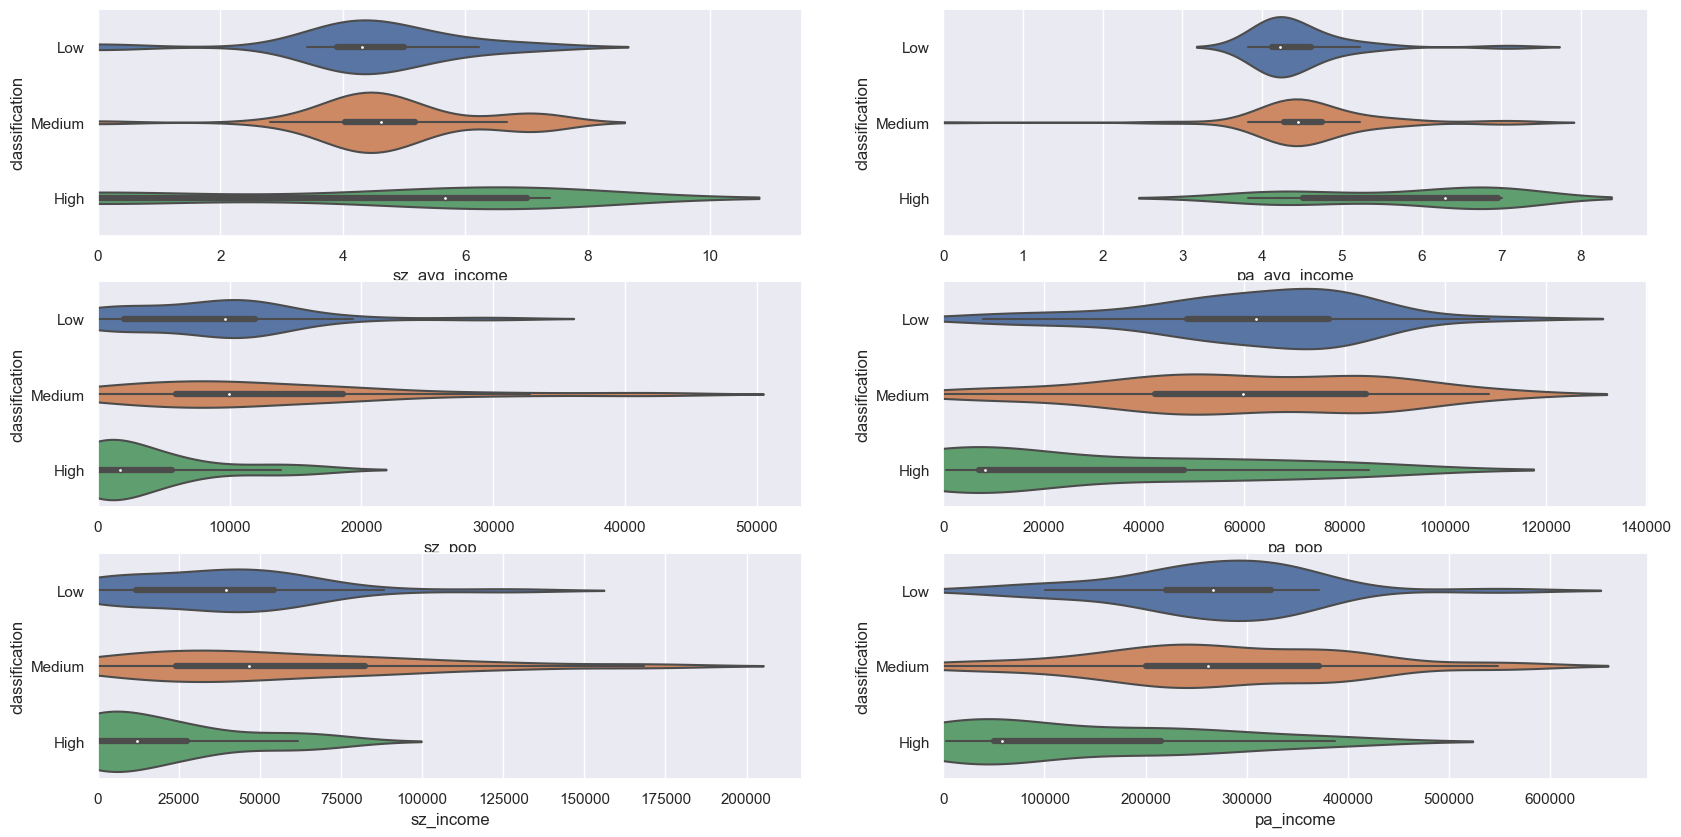

In [334]:
# plot classification against pa_population, pa_income, subzone_population and subzone_income
fig, ax = plt.subplots(3,2, figsize=(20,10))
sns.violinplot(x='sz_avg_income', y='classification', data=mcd_df, ax=ax[0,0])
sns.violinplot(x='pa_avg_income', y='classification', data=mcd_df, ax=ax[0,1])
sns.violinplot(x='sz_pop', y='classification', data=mcd_df, ax=ax[1,0])
sns.violinplot(x='pa_pop', y='classification', data=mcd_df, ax=ax[1,1])
sns.violinplot(x='sz_income', y='classification', data=mcd_df, ax=ax[2,0])
sns.violinplot(x='pa_income', y='classification', data=mcd_df, ax=ax[2,1])

# set limit of 0 for all axis
for i in range(3):
    for j in range(2):
        ax[i,j].set_xlim(0) 

plt.show()

- If any of the population metrics are used, there can be difficulty for the model to learn between Medium and Low McDonald's
- "High" McDonald's are correlated to low total population and income areas. 

In [299]:
# convert "classification" to dummy values and then plot a correlation matrix without latitude and longitude
mcd_df_dummies = pd.get_dummies(mcd_df, columns=['classification'])

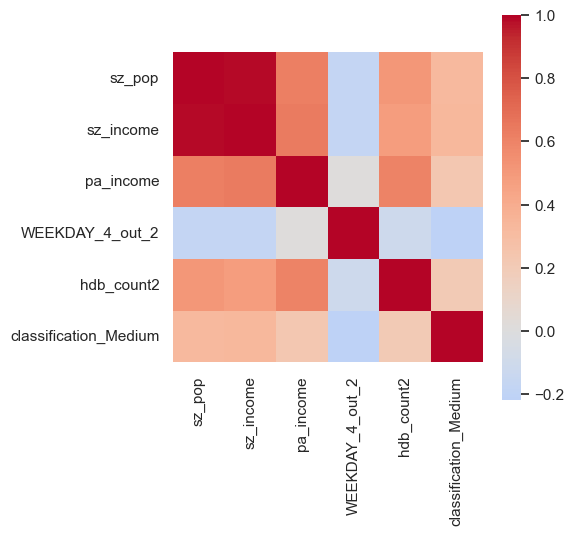

In [360]:
# lets see what are the most correlated features with each of the target classification
threshold = 0.2 # this number is determined after trial and error and getting 5/6 features correlated

# drop the column for low and high classifications in mcd_df
corr = mcd_df_dummies.drop(['classification_Low', 'classification_High'], axis=1)
corr_matrix = corr.corr(numeric_only=True)

# Filter out correlations above X for the target variable y
y_corr = corr_matrix['classification_Medium']
med_corr_filtered = y_corr[abs(y_corr) >= threshold]

# Create a new correlation matrix with only the filtered correlations
corr_matrix_filtered = corr_matrix.loc[med_corr_filtered.index, med_corr_filtered.index]

# Plot the filtered correlation matrix as a heatmap
sns.set()
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr_matrix_filtered, cmap='coolwarm', center=0, square=True, ax=ax)
plt.show()

"Medium" McDonald's are correlated to total population and income indicating there are mostly located in high population areas. However there was that issue of using population statistics

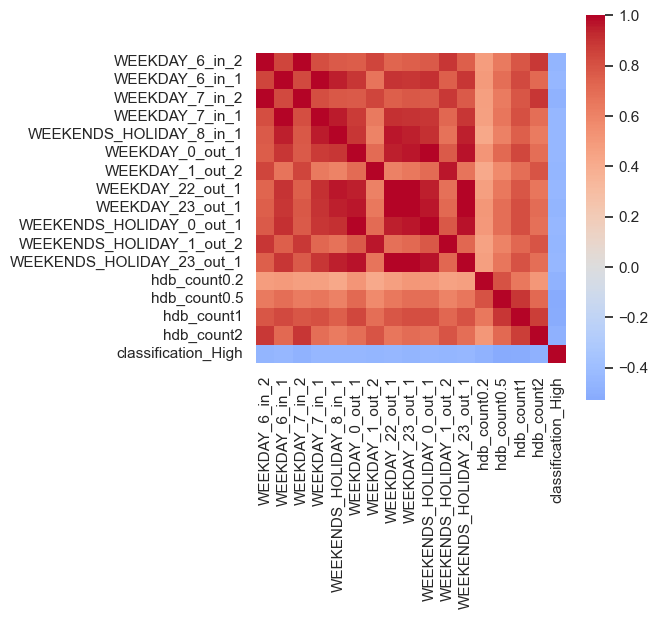

In [361]:
# lets see what are the most correlated features with each of the target classification
threshold = 0.44 # this number is determined after trial and error and getting 5/6 features correlated

# drop the column for other classifications in mcd_df
corr = mcd_df_dummies.drop(['classification_Low', 'classification_Medium'], axis=1)
corr_matrix = corr.corr(numeric_only=True)

# Filter out correlations above X for the target variable y
y_corr = corr_matrix['classification_High']
high_corr_filtered = y_corr[abs(y_corr) >= threshold]

# Create a new correlation matrix with only the filtered correlations
corr_matrix_filtered = corr_matrix.loc[high_corr_filtered.index, high_corr_filtered.index]

# Plot the filtered correlation matrix as a heatmap
sns.set()
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr_matrix_filtered, cmap='coolwarm', center=0, square=True, ax=ax)
plt.show()

We can see that for the "High" McDonald's, its quite negatively correlated with people leaving in the morning and people returning at night. Generally areas with low traffic and public housing are going to be "High"

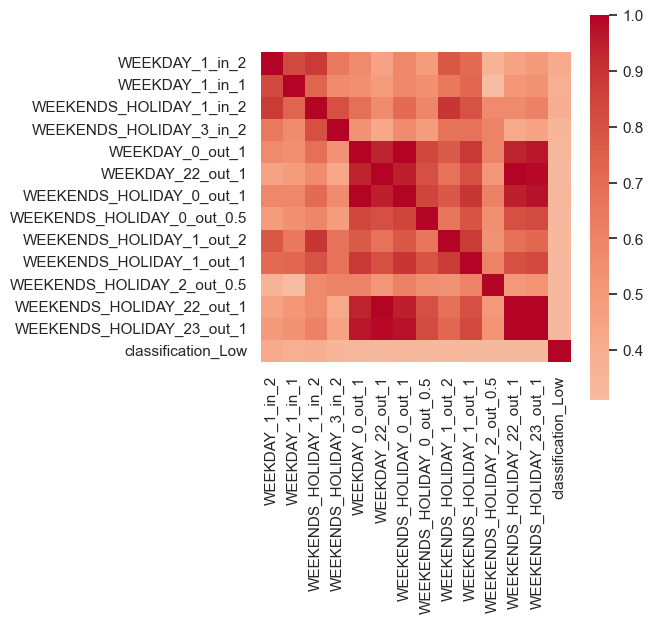

In [362]:
# lets see what are the most correlated features with each of the target classification
threshold = 0.32 # this number is determined after trial and error and getting 5/6 features correlated

# drop the column for other classifications in mcd_df
corr = mcd_df_dummies.drop(['classification_High', 'classification_Medium'], axis=1)
corr_matrix = corr.corr(numeric_only=True)

# Filter out correlations above X for the target variable y
y_corr = corr_matrix['classification_Low']
low_corr_filtered = y_corr[abs(y_corr) >= threshold]

# Create a new correlation matrix with only the filtered correlations
corr_matrix_filtered = corr_matrix.loc[low_corr_filtered.index, low_corr_filtered.index]

# Plot the filtered correlation matrix as a heatmap
sns.set()
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr_matrix_filtered, cmap='coolwarm', center=0, square=True, ax=ax)
plt.show()

Conversely we can see that for the "Low" McDonald's, its quite postively correlated with people leaving and coming back in the wee hours of the night

### Categorical Features

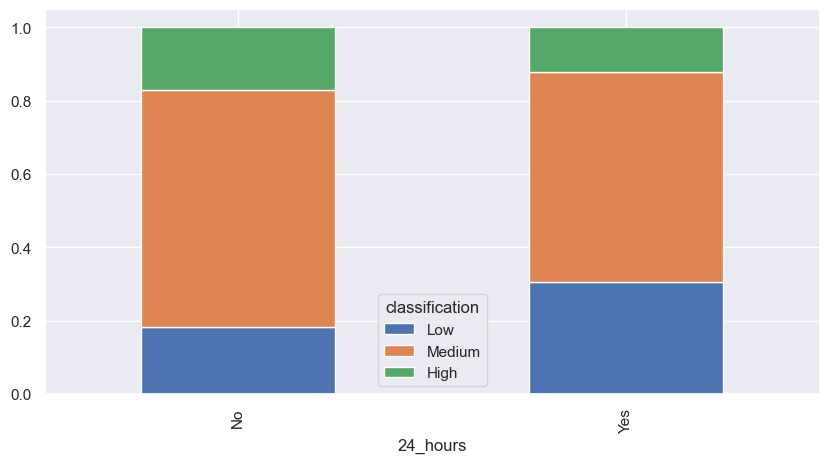

In [305]:
# do a normalized count of classification (without Tourist and Student) against 24 hours?
pd.crosstab(mcd_df['24_hours'], mcd_df['classification']).apply(lambda r: r/r.sum(), axis=1).plot(kind='bar', stacked=True, figsize=(10,5))
plt.show()

In [306]:
# There are way too many columns so we will select the "best" features to train our model
len(mcd_df.columns)

405

In [338]:
features = [high_corr_filtered.index.tolist(),
            low_corr_filtered.index.tolist(),
            med_corr_filtered.index.tolist()]

# remove duplicates in features
features = list(set([item for sublist in features for item in sublist]))

# remove classification_Low, classification_Medium and classification_High since these are the dummified values
features.remove('classification_Low')
features.remove('classification_Medium')
features.remove('classification_High')

# add classification back to features
features.append('classification')

print(features)

['WEEKDAY_7_in_2', 'WEEKDAY_4_out_2', 'sz_income', 'WEEKDAY_22_out_1', 'sz_pop', 'hdb_count1', 'WEEKDAY_7_in_1', 'WEEKDAY_6_in_1', 'WEEKDAY_23_out_1', 'WEEKENDS_HOLIDAY_1_in_2', 'WEEKENDS_HOLIDAY_3_in_2', 'pa_income', 'WEEKENDS_HOLIDAY_23_out_1', 'WEEKENDS_HOLIDAY_0_out_1', 'WEEKENDS_HOLIDAY_2_out_0.5', 'WEEKENDS_HOLIDAY_1_out_2', 'WEEKDAY_6_in_2', 'WEEKDAY_0_out_1', 'WEEKDAY_1_in_1', 'WEEKENDS_HOLIDAY_1_out_1', 'WEEKDAY_1_in_2', 'hdb_count2', 'WEEKDAY_1_out_2', 'hdb_count0.2', 'WEEKENDS_HOLIDAY_22_out_1', 'WEEKENDS_HOLIDAY_8_in_1', 'hdb_count0.5', 'WEEKENDS_HOLIDAY_0_out_0.5', 'classification']


In [339]:
mcd_df_model = mcd_df[features]

# Modelling

## First Model

In [340]:
# set the lucky number for random state
rs = 42

In [471]:
# train a RF classifier
X = mcd_df_model.drop('classification', axis=1)
y = mcd_df_model['classification']

# remove the categorical aspect of y since we don't want it to be treated as a category
y = y.astype('object')

# convert X.columns to a list
X.col = list(X.columns)

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()
print(f'numerical features used are {numerical_features}')
print(f'categorical features used are {categorical_features}')
print()

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

# Preprocessing, there's actually no need for RF but its part of my own template
preprocessor = ColumnTransformer(transformers=[
    ('tnf1',MinMaxScaler(),numerical_features),
    ('tnf3',OneHotEncoder(),categorical_features)
    ])

# Do class balancing
smote = SMOTE(random_state=rs)

# Implement a random forest
rf = RandomForestClassifier(random_state=rs)

# create a dictionary of all values we want to test for random forest
params = {
    'classifier__n_estimators': [300, 500, 800],
    'classifier__max_depth': [4, 5, 6],
}

pipeline = imbPipeline(steps=[('preprocessor', preprocessor),('smote',smote),('classifier', rf)])

# instantiate the gridsearch
grid = GridSearchCV(pipeline, params, cv=5, scoring ='accuracy', verbose=2)

# fit model to data
grid.fit(X_train, y_train)

# predict the test data
y_pred = grid.predict(X_test)

# print the best parameters
print('The best parameters and cross validated accuracy score is:')
print(grid.best_params_)
print(f'the range of scores can be {cross_val_score(grid.best_estimator_, X_train, y_train, cv=5)}')
print(f'{grid.best_score_}')

/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_7630/3173169926.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X.col = list(X.columns)


numerical features used are ['WEEKDAY_7_in_2', 'WEEKDAY_4_out_2', 'sz_income', 'WEEKDAY_22_out_1', 'sz_pop', 'hdb_count1', 'WEEKDAY_7_in_1', 'WEEKDAY_6_in_1', 'WEEKDAY_23_out_1', 'WEEKENDS_HOLIDAY_1_in_2', 'WEEKENDS_HOLIDAY_3_in_2', 'pa_income', 'WEEKENDS_HOLIDAY_23_out_1', 'WEEKENDS_HOLIDAY_0_out_1', 'WEEKENDS_HOLIDAY_2_out_0.5', 'WEEKENDS_HOLIDAY_1_out_2', 'WEEKDAY_6_in_2', 'WEEKDAY_0_out_1', 'WEEKDAY_1_in_1', 'WEEKENDS_HOLIDAY_1_out_1', 'WEEKDAY_1_in_2', 'hdb_count2', 'WEEKDAY_1_out_2', 'hdb_count0.2', 'WEEKENDS_HOLIDAY_22_out_1', 'WEEKENDS_HOLIDAY_8_in_1', 'hdb_count0.5', 'WEEKENDS_HOLIDAY_0_out_0.5']
categorical features used are []

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END classifier__max_depth=4, classifier__n_estimators=300; total time=   0.2s
[CV] END classifier__max_depth=4, classifier__n_estimators=300; total time=   0.1s
[CV] END classifier__max_depth=4, classifier__n_estimators=300; total time=   0.1s
[CV] END classifier__max_depth=4, classifier

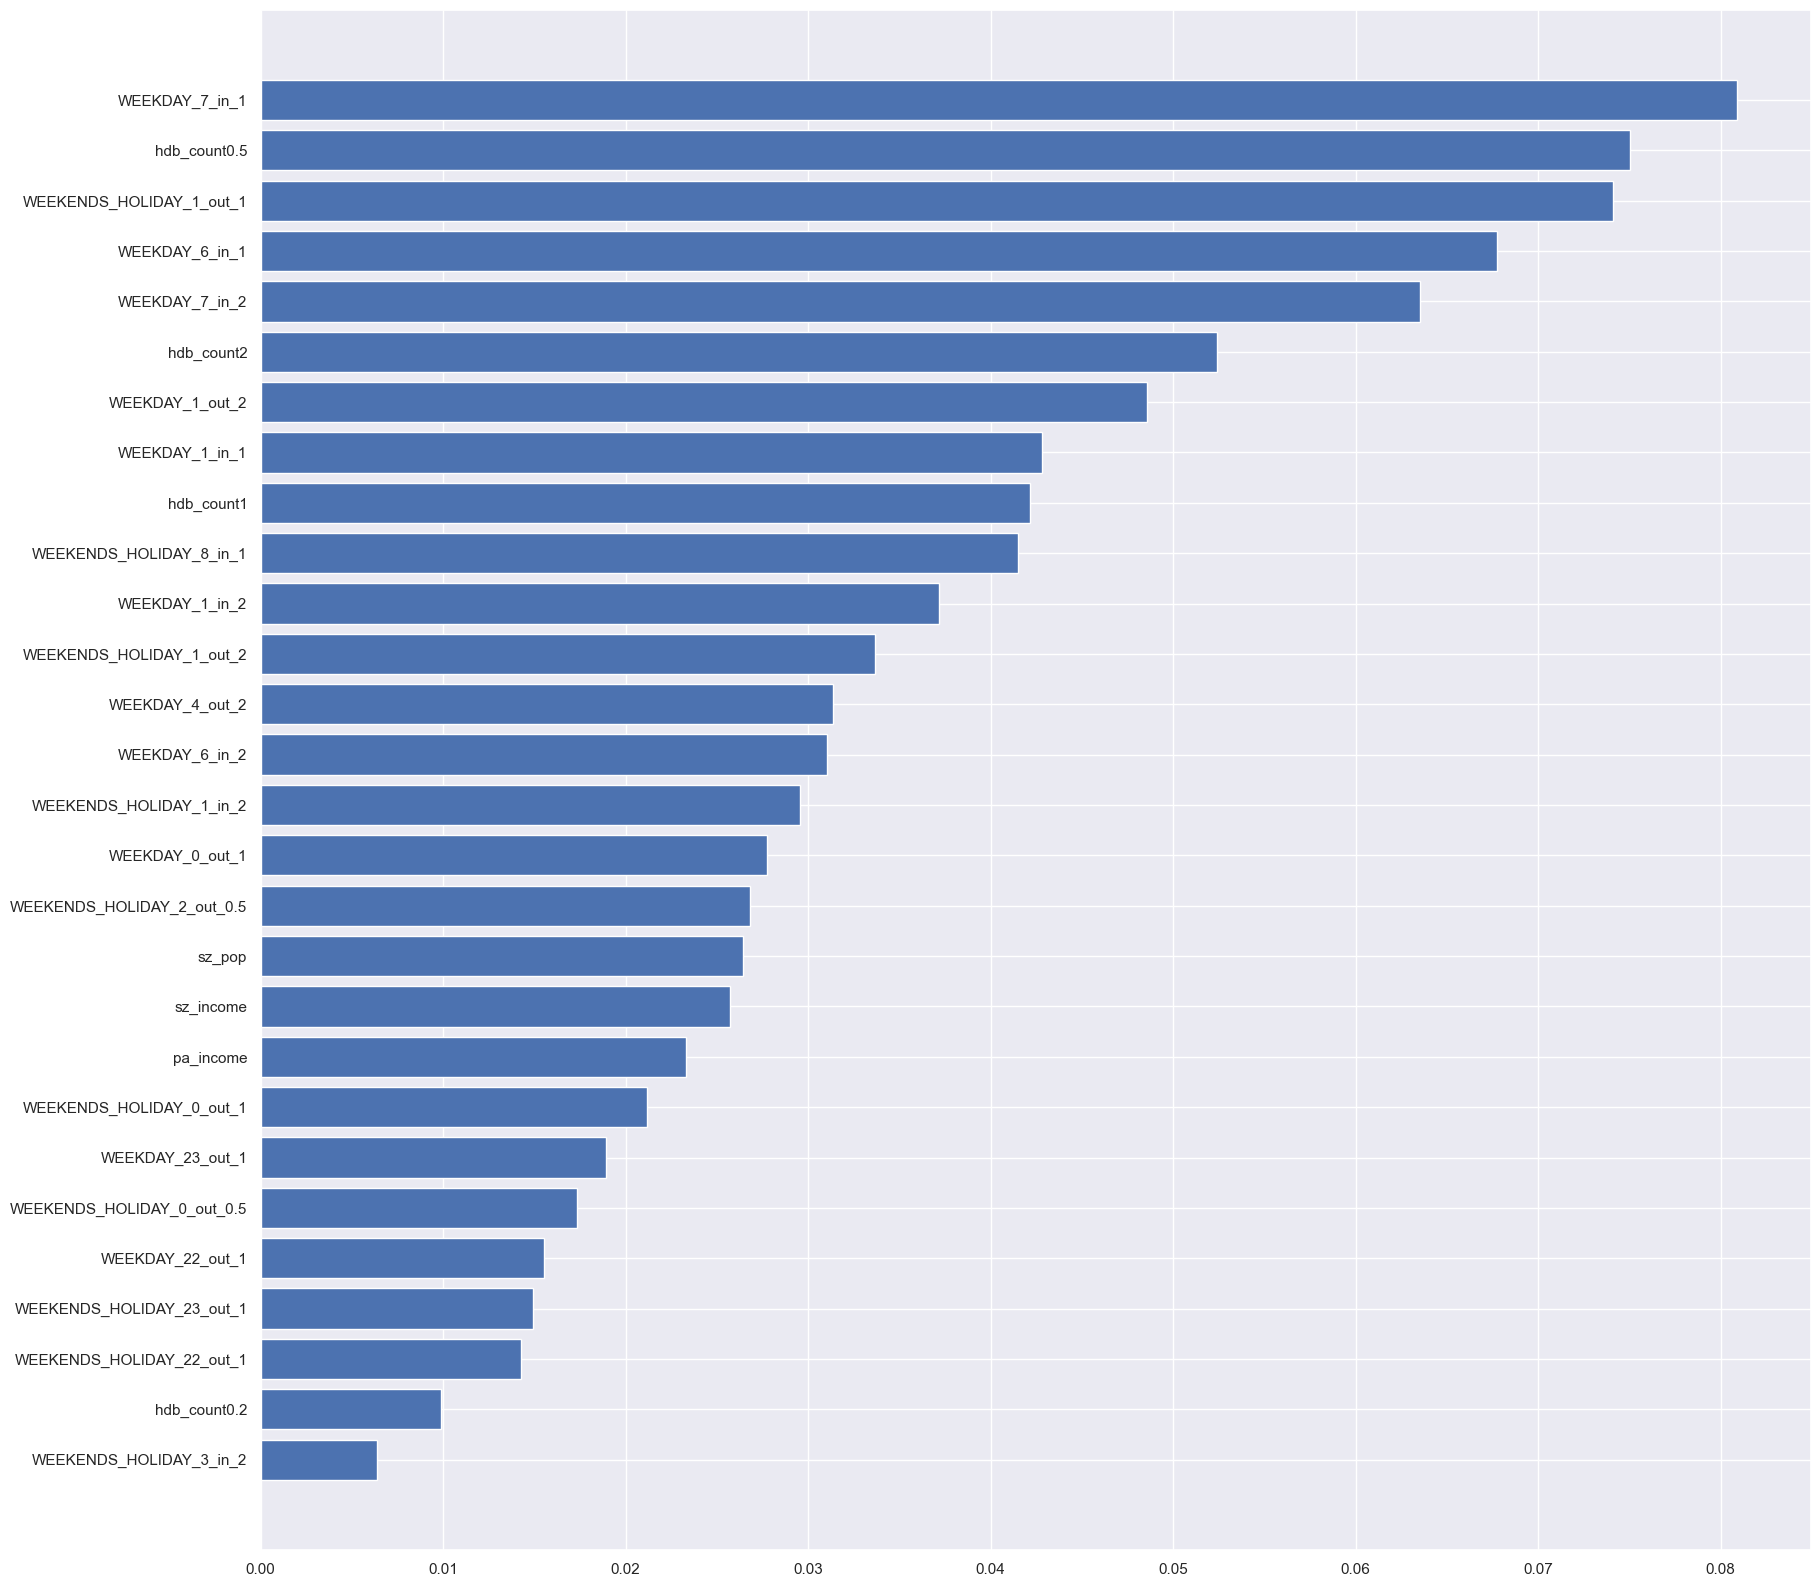

In [472]:
# change fig size to fit all the axis labels
plt.figure(figsize=(20,20))

# get the best features in the RF
best = grid.best_estimator_
f_i = list(zip(X.columns,best.named_steps['classifier'].feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [473]:
# print the classification report for the best estimator of the gridsearch results
y_pred = grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

        High       0.33      0.17      0.22         6
         Low       0.50      0.40      0.44         5
      Medium       0.63      0.80      0.71        15

    accuracy                           0.58        26
   macro avg       0.49      0.46      0.46        26
weighted avg       0.54      0.58      0.54        26

Accuracy: 0.58

Balanced Accuracy: 0.46



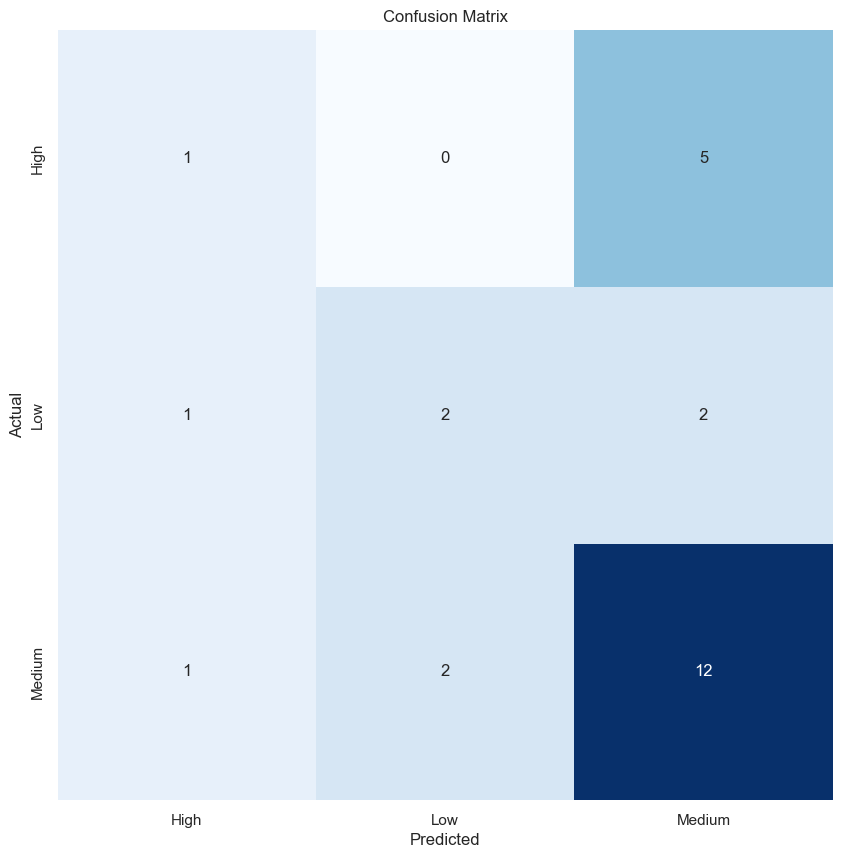

In [474]:
# print confusion matrix with the predicted and actual correct with colors
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')

plt.xlabel('Predicted')
plt.ylabel('Actual')

# put labels on the predicted and actual labels
plt.xticks([0.5,1.5,2.5], ['High', 'Low', 'Medium'])
plt.yticks([0.5,1.5,2.5], ['High', 'Low', 'Medium'])

plt.show()

There is a clear issue with predicting medium for high McDonald's

In [477]:
# investigate differences between y_test and y_pred for wrong results
y_test = y_test.reset_index(drop=True)
y_pred = pd.Series(y_pred)
y_pred = y_pred.reset_index(drop=True)
y_diff = pd.concat([y_test, y_pred], axis=1)
y_diff.columns = ['y_test', 'y_pred']
y_diff['diff'] = y_diff['y_test'] == y_diff['y_pred']
y_diff['diff'] = y_diff['diff'].astype('int')

# get the y_pred for the wrong results only
results = y_diff[y_diff['diff']==0]['y_pred']

# get the index of y_diff['diff'] and print the same index values of X_test
print(X_test.iloc[y_diff[y_diff['diff'] == 0].index])

     WEEKDAY_7_in_2  WEEKDAY_4_out_2  sz_income  WEEKDAY_22_out_1  sz_pop  \
77        718440.00            82.00   25070.00         114631.00    6030   
88        145963.00             0.00   15630.00          10299.00    2250   
35        493992.00            23.00   32800.00          67028.00    5580   
4         744702.00             1.00   61630.00          70794.00   11270   
40        838554.00             0.00   67330.00         116305.00   15680   
111       579396.00            40.00   25830.00          19746.00    5890   
89        616917.00             7.00   25080.00          54050.00    3580   
105       642300.00             5.00   34740.00         117548.00    7530   
62        663521.00             0.00   47140.00          31822.00    6700   
28       1005648.00             5.00   61250.00          95242.00   12370   
87        237848.00             0.00   39470.00          14244.00    5560   

     hdb_count1  WEEKDAY_7_in_1  WEEKDAY_6_in_1  WEEKDAY_23_out_1  \
77    

In [482]:
# print out all of the index values in mcd_df with respect to X_test.iloc[y_diff[y_diff['diff'] == 0].index]
evaluate = pd.concat([(mcd_df.loc[[77,88,35,4,40,111,89,105,62,28,87],:]).reset_index(),results.reset_index()], axis=1)

In [483]:
# right results
right_results = y_diff[y_diff['diff']==1]['y_pred']

# print out all of the index values in mcd_df with respect to X_test.iloc[y_diff[y_diff['diff'] == 0].index]
right_evaluate = pd.concat([mcd_df.drop([88,35,4,40,111,89,105,62,28,87]),right_results.reset_index()], axis=1)

### First Model Evaluation
We know what are the factors that most likely make up "High", "Low" and "Medium" from our EDA so lets see where our model failed
From the confusion matrix its also obvious that precision for High and Low are the highest priority to fix

#### Wrong Predictions
First lets look at the "Medium" predictions but were actually "High" from the confusion matrix

In [484]:
new_eval = evaluate[evaluate['y_pred']=='Medium']
# lets drop the low classifications since we want to evaluate the high only
evaluate_high = new_eval[new_eval['classification']!='Low']
print(evaluate_high.title)

2           McDonald's Kallang (Stadium)
3    McDonald's Pasir Ris Sports Complex
5                 McDonald's TradeHub 21
6            McDonald's Great World City
8               McDonald's United Square
Name: title, dtype: object


In [485]:
high_list = high_corr_filtered.index.tolist()
high_list.remove('classification_High')
Evaluate().mean_metrics('Medium',high_list, mcd_df_model, evaluate_high, right_evaluate)

the % difference between the average of WEEKDAY_6_in_2 and the wrong prediction of Medium is 21.97%
the % difference between the average of WEEKDAY_6_in_2 and the right prediction of Medium is -24.67%

the % difference between the average of WEEKDAY_6_in_1 and the wrong prediction of Medium is 50.89%
the % difference between the average of WEEKDAY_6_in_1 and the right prediction of Medium is -13.08%

the % difference between the average of WEEKDAY_7_in_2 and the wrong prediction of Medium is 16.91%
the % difference between the average of WEEKDAY_7_in_2 and the right prediction of Medium is -22.95%

the % difference between the average of WEEKDAY_7_in_1 and the wrong prediction of Medium is 45.20%
the % difference between the average of WEEKDAY_7_in_1 and the right prediction of Medium is -8.15%

the % difference between the average of WEEKENDS_HOLIDAY_8_in_1 and the wrong prediction of Medium is 37.39%
the % difference between the average of WEEKENDS_HOLIDAY_8_in_1 and the right predic

In [486]:
high_list = high_corr_filtered.index.tolist()
high_list.remove('classification_High')
Evaluate().median_metrics('Medium',high_list, mcd_df_model, evaluate_high, right_evaluate)

the % difference between the median of WEEKDAY_6_in_2 and the wrong prediction of Medium is 25.19%
the % difference between the median of WEEKDAY_6_in_2 and the right prediction of Medium is -31.60%

the % difference between the median of WEEKDAY_6_in_1 and the wrong prediction of Medium is 50.68%
the % difference between the median of WEEKDAY_6_in_1 and the right prediction of Medium is -19.29%

the % difference between the median of WEEKDAY_7_in_2 and the wrong prediction of Medium is 20.54%
the % difference between the median of WEEKDAY_7_in_2 and the right prediction of Medium is -27.91%

the % difference between the median of WEEKDAY_7_in_1 and the wrong prediction of Medium is 40.63%
the % difference between the median of WEEKDAY_7_in_1 and the right prediction of Medium is -17.01%

the % difference between the median of WEEKENDS_HOLIDAY_8_in_1 and the wrong prediction of Medium is 21.80%
the % difference between the median of WEEKENDS_HOLIDAY_8_in_1 and the right prediction of M

There are a few problems noted
1. The kfolds CV results are showing results with a large variance so we should do a stratified Kfolds instead
2. The accuracy for test is not that great, we should try to improve it but it seems like feature selection is not the key

## Second Model

Lets try to stratify the samples first

In [487]:
# train a RF classifier
rs = 42
X = mcd_df_model.drop('classification', axis=1)
y = mcd_df_model['classification']

# remove the categorical aspect of y since we don't want it to be treated as a category
y = y.astype('object')


# convert X.columns to a list
X.col = list(X.columns)

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()
print(f'numerical features used are {numerical_features}')
print(f'categorical features used are {categorical_features}')
print()

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs,stratify=y)

# Preprocessing, there's actually no need for RF but its part of my own template
preprocessor = ColumnTransformer(transformers=[
    ('tnf1',MinMaxScaler(),numerical_features),
    ('tnf3',OneHotEncoder(),categorical_features)
    ])

# Do class balancing
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)

# Implement a random forest
rf = RandomForestClassifier(random_state=rs, class_weight='balanced_subsample')

# create a dictionary of all values we want to test for random forest
params = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [4, 5, 6],
    # 'classifier__min_samples_split': [2, 3, 4],
    # 'classifier__min_samples_leaf': [1, 2],
    # 'classifier__max_features': ['sqrt', 'log2']
}

pipeline = imbPipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', rf)])

# instantiate the gridsearch
grid = GridSearchCV(pipeline, params, cv=skf, scoring ='accuracy', verbose=2)

# fit model to data
grid.fit(X_train, y_train)

# predict the test data
y_pred = grid.predict(X_test)

# print the best parameters
print('The best parameters and cross validated accuracy score is:')
print(grid.best_params_)
print(f'the range of scores can be {cross_val_score(grid.best_estimator_, X_train, y_train, cv=skf)}')
print(f'{grid.best_score_}')

/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_7630/3858497706.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X.col = list(X.columns)


numerical features used are ['WEEKDAY_7_in_2', 'WEEKDAY_4_out_2', 'sz_income', 'WEEKDAY_22_out_1', 'sz_pop', 'hdb_count1', 'WEEKDAY_7_in_1', 'WEEKDAY_6_in_1', 'WEEKDAY_23_out_1', 'WEEKENDS_HOLIDAY_1_in_2', 'WEEKENDS_HOLIDAY_3_in_2', 'pa_income', 'WEEKENDS_HOLIDAY_23_out_1', 'WEEKENDS_HOLIDAY_0_out_1', 'WEEKENDS_HOLIDAY_2_out_0.5', 'WEEKENDS_HOLIDAY_1_out_2', 'WEEKDAY_6_in_2', 'WEEKDAY_0_out_1', 'WEEKDAY_1_in_1', 'WEEKENDS_HOLIDAY_1_out_1', 'WEEKDAY_1_in_2', 'hdb_count2', 'WEEKDAY_1_out_2', 'hdb_count0.2', 'WEEKENDS_HOLIDAY_22_out_1', 'WEEKENDS_HOLIDAY_8_in_1', 'hdb_count0.5', 'WEEKENDS_HOLIDAY_0_out_0.5']
categorical features used are []

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END classifier__max_depth=4, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=4, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=4, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=4, classifier

              precision    recall  f1-score   support

        High       0.67      0.50      0.57         4
         Low       0.80      0.67      0.73         6
      Medium       0.78      0.88      0.82        16

    accuracy                           0.77        26
   macro avg       0.75      0.68      0.71        26
weighted avg       0.77      0.77      0.76        26

Accuracy: 0.77

Balanced Accuracy: 0.68



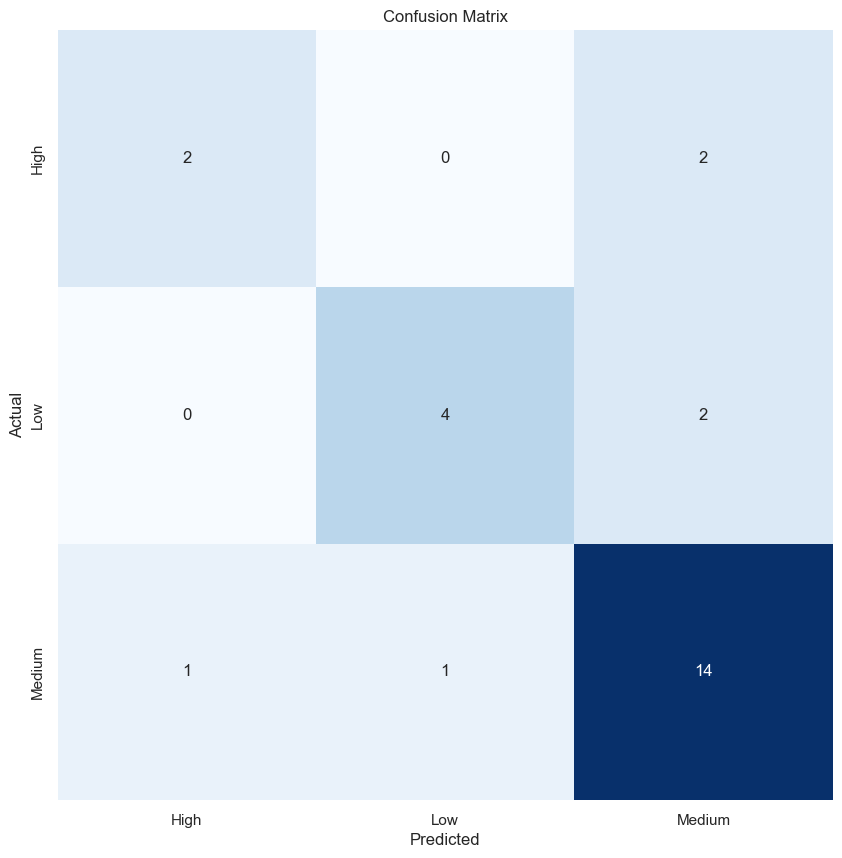

In [488]:
# print the classification report for the best estimator of the gridsearch results
y_pred = grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))
# print confusion matrix with the predicted and actual correct with colors
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')

plt.xlabel('Predicted')
plt.ylabel('Actual')

# put labels on the predicted and actual labels
plt.xticks([0.5,1.5,2.5], ['High', 'Low', 'Medium'])
plt.yticks([0.5,1.5,2.5], ['High', 'Low', 'Medium'])

plt.show()

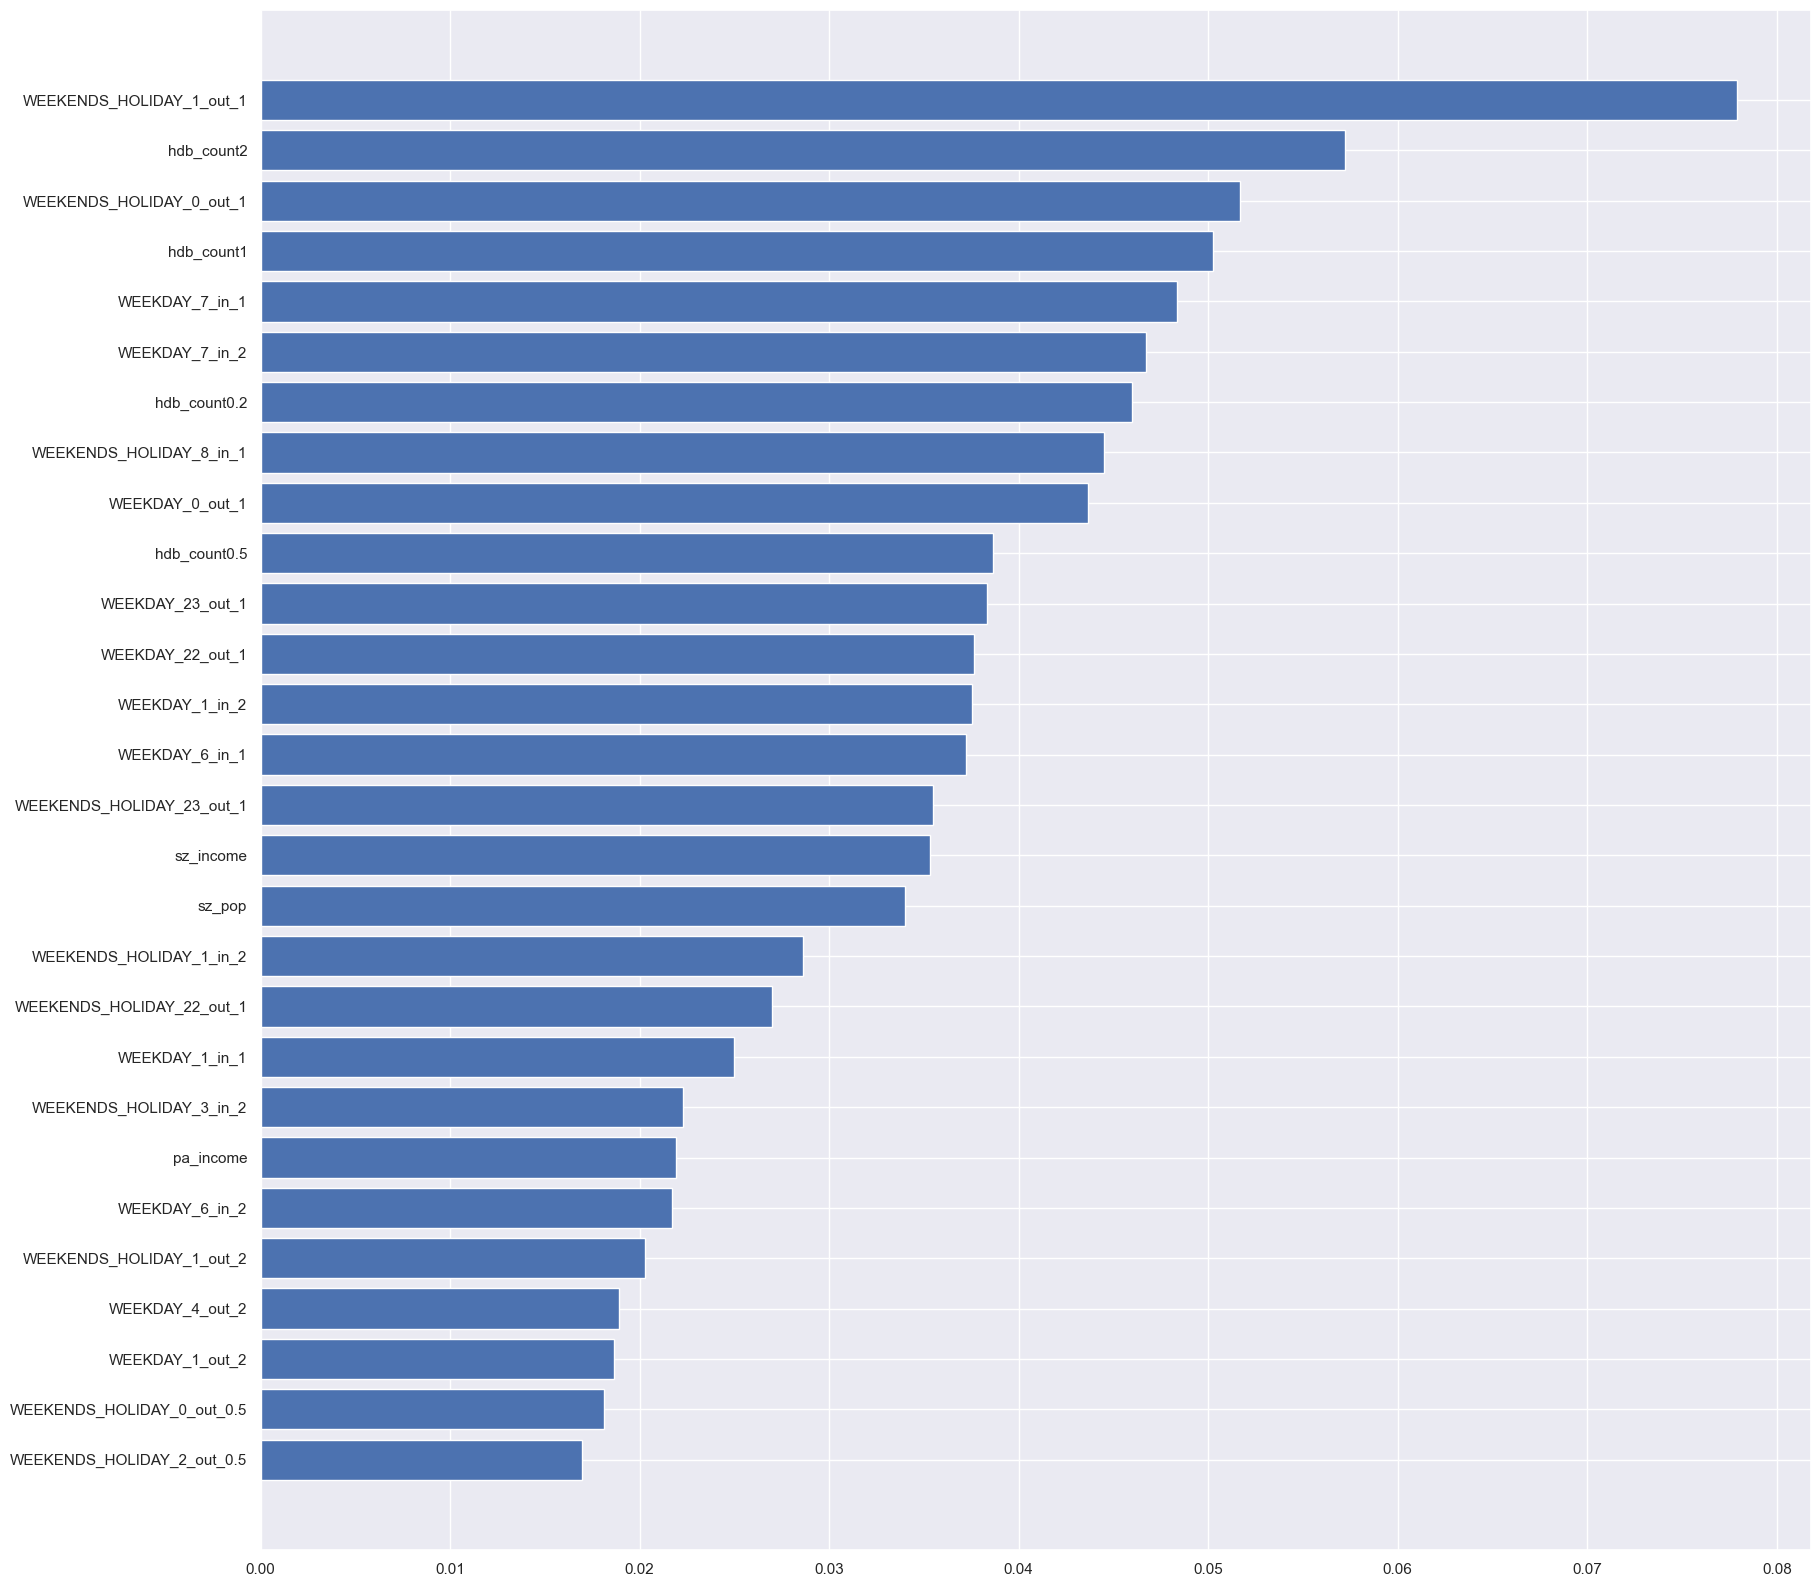

In [502]:
# change fig size to fit all the axis labels
plt.figure(figsize=(20,20))

# get the best features in the RF
best = grid.best_estimator_
f_i = list(zip(X.columns,best.named_steps['classifier'].feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [489]:
# investigate differences between y_test and y_pred for wrong results
y_test = y_test.reset_index(drop=True)
y_pred = pd.Series(y_pred)
y_pred = y_pred.reset_index(drop=True)
y_diff = pd.concat([y_test, y_pred], axis=1)
y_diff.columns = ['y_test', 'y_pred']
y_diff['diff'] = y_diff['y_test'] == y_diff['y_pred']
y_diff['diff'] = y_diff['diff'].astype('int')

# get the y_pred for the wrong results only
results = y_diff[y_diff['diff']==0]['y_pred']

# get the index of y_diff['diff'] and print the same index values of X_test
print(X_test.iloc[y_diff[y_diff['diff'] == 0].index])

     WEEKDAY_7_in_2  WEEKDAY_4_out_2  sz_income  WEEKDAY_22_out_1  sz_pop  \
8         930985.00             1.00   61630.00          60991.00   11270   
116       987353.00            11.00   53180.00         115971.00   11630   
3         811828.00            13.00   54030.00          62719.00   12330   
89        616917.00             7.00   25080.00          54050.00    3580   
62        663521.00             0.00   47140.00          31822.00    6700   
100       193674.00             0.00   51890.00          31957.00    7770   

     hdb_count1  WEEKDAY_7_in_1  WEEKDAY_6_in_1  WEEKDAY_23_out_1  \
8           210       222331.00       150785.00          34379.00   
116         280       429663.00       293360.00          70823.00   
3           164       205555.00       137230.00          35571.00   
89          117       135344.00        76706.00          27635.00   
62           26       104821.00        49539.00          15429.00   
100          21        87662.00        46786.0

In [490]:
# print out all of the index values in mcd_df with respect to X_test.iloc[y_diff[y_diff['diff'] == 0].index]
evaluate = pd.concat([(mcd_df.loc[[8,116,3,89,62,100],:]).reset_index(),results.reset_index()], axis=1)

In [491]:
# right results
right_results = y_diff[y_diff['diff']==1]['y_pred']

# print out all of the index values in mcd_df with respect to X_test.iloc[y_diff[y_diff['diff'] == 0].index]
right_evaluate = pd.concat([mcd_df.drop([88,35,4,40,111,89,105,62,28,87]),right_results.reset_index()], axis=1)

In [494]:
new_eval = evaluate[evaluate['y_pred']=='Medium']
# lets drop the low classifications since we want to evaluate the high only
evaluate_high = new_eval[new_eval['classification']!='Low']
print(evaluate_high.title)

3    McDonald's Great World City
4       McDonald's United Square
Name: title, dtype: object


In [496]:
high_list = high_corr_filtered.index.tolist()
high_list.remove('classification_High')
Evaluate().mean_metrics('Medium',high_list, mcd_df_model, evaluate_high, right_evaluate)

the % difference between the average of WEEKDAY_6_in_2 and the wrong prediction of Medium is 26.54%
the % difference between the average of WEEKDAY_6_in_2 and the right prediction of Medium is -17.45%

the % difference between the average of WEEKDAY_6_in_1 and the wrong prediction of Medium is 64.67%
the % difference between the average of WEEKDAY_6_in_1 and the right prediction of Medium is -1.69%

the % difference between the average of WEEKDAY_7_in_2 and the wrong prediction of Medium is 14.16%
the % difference between the average of WEEKDAY_7_in_2 and the right prediction of Medium is -17.08%

the % difference between the average of WEEKDAY_7_in_1 and the wrong prediction of Medium is 54.87%
the % difference between the average of WEEKDAY_7_in_1 and the right prediction of Medium is -0.31%

the % difference between the average of WEEKENDS_HOLIDAY_8_in_1 and the wrong prediction of Medium is 35.89%
the % difference between the average of WEEKENDS_HOLIDAY_8_in_1 and the right predict

In [497]:
high_list = high_corr_filtered.index.tolist()
high_list.remove('classification_High')
Evaluate().median_metrics('Medium',high_list, mcd_df_model, evaluate_high, right_evaluate)

the % difference between the median of WEEKDAY_6_in_2 and the wrong prediction of Medium is 28.36%
the % difference between the median of WEEKDAY_6_in_2 and the right prediction of Medium is -26.99%

the % difference between the median of WEEKDAY_6_in_1 and the wrong prediction of Medium is 59.41%
the % difference between the median of WEEKDAY_6_in_1 and the right prediction of Medium is 3.04%

the % difference between the median of WEEKDAY_7_in_2 and the wrong prediction of Medium is 17.54%
the % difference between the median of WEEKDAY_7_in_2 and the right prediction of Medium is -27.38%

the % difference between the median of WEEKDAY_7_in_1 and the wrong prediction of Medium is 47.32%
the % difference between the median of WEEKDAY_7_in_1 and the right prediction of Medium is 3.38%

the % difference between the median of WEEKENDS_HOLIDAY_8_in_1 and the wrong prediction of Medium is 29.87%
the % difference between the median of WEEKENDS_HOLIDAY_8_in_1 and the right prediction of Mediu

In [499]:
new_eval = evaluate[evaluate['y_pred']=='Medium']
# lets drop the low classifications since we want to evaluate the high only
evaluate_low = new_eval[new_eval['classification']!='High']
print(evaluate_low.title)

0    McDonald's White Sands Pasir Ris Central
2                  McDonald's Bedok Reservoir
Name: title, dtype: object


In [504]:
low_list = low_corr_filtered.index.tolist()
low_list.remove('classification_Low')
Evaluate().mean_metrics('Medium',low_list, mcd_df_model, evaluate_high, right_evaluate)

the % difference between the average of WEEKDAY_1_in_2 and the wrong prediction of Medium is 78.37%
the % difference between the average of WEEKDAY_1_in_2 and the right prediction of Medium is -11.62%

the % difference between the average of WEEKDAY_1_in_1 and the wrong prediction of Medium is 93.27%
the % difference between the average of WEEKDAY_1_in_1 and the right prediction of Medium is 17.84%

the % difference between the average of WEEKENDS_HOLIDAY_1_in_2 and the wrong prediction of Medium is 52.41%
the % difference between the average of WEEKENDS_HOLIDAY_1_in_2 and the right prediction of Medium is -29.46%

the % difference between the average of WEEKENDS_HOLIDAY_3_in_2 and the wrong prediction of Medium is 97.19%
the % difference between the average of WEEKENDS_HOLIDAY_3_in_2 and the right prediction of Medium is 18.18%

the % difference between the average of WEEKDAY_0_out_1 and the wrong prediction of Medium is 61.35%
the % difference between the average of WEEKDAY_0_out_1 a

In [503]:
low_list = low_corr_filtered.index.tolist()
low_list.remove('classification_Low')
Evaluate().median_metrics('Medium',low_list, mcd_df_model, evaluate_high, right_evaluate)

the % difference between the median of WEEKDAY_1_in_2 and the wrong prediction of Medium is 72.82%
the % difference between the median of WEEKDAY_1_in_2 and the right prediction of Medium is -51.88%

the % difference between the median of WEEKDAY_1_in_1 and the wrong prediction of Medium is 86.65%
the % difference between the median of WEEKDAY_1_in_1 and the right prediction of Medium is -27.40%

the % difference between the median of WEEKENDS_HOLIDAY_1_in_2 and the wrong prediction of Medium is 56.65%
the % difference between the median of WEEKENDS_HOLIDAY_1_in_2 and the right prediction of Medium is -42.33%

the % difference between the median of WEEKENDS_HOLIDAY_3_in_2 and the wrong prediction of Medium is 93.33%
the % difference between the median of WEEKENDS_HOLIDAY_3_in_2 and the right prediction of Medium is -140.00%

the % difference between the median of WEEKDAY_0_out_1 and the wrong prediction of Medium is 56.59%
the % difference between the median of WEEKDAY_0_out_1 and the 

## Third Model

In [510]:
# We try to group similar times together to see if we can get a better result
mcd_df_model['morning_traffic']=mcd_df_model['WEEKDAY_6_in_1']+mcd_df_model['WEEKDAY_7_in_1']+mcd_df_model['WEEKENDS_HOLIDAY_8_in_1']
mcd_df_model['late_traffic']=mcd_df_model['WEEKDAY_1_in_1']+mcd_df_model['WEEKENDS_HOLIDAY_0_out_1']+mcd_df_model['WEEKDAY_22_out_1']+mcd_df_model['WEEKENDS_HOLIDAY_22_out_1']+mcd_df_model['WEEKDAY_23_out_1']+mcd_df_model['WEEKENDS_HOLIDAY_23_out_1']+mcd_df_model['WEEKENDS_HOLIDAY_1_out_1']

/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_7630/2961318500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcd_df_model['morning_traffic']=mcd_df_model['WEEKDAY_6_in_1']+mcd_df_model['WEEKDAY_7_in_1']+mcd_df_model['WEEKENDS_HOLIDAY_8_in_1']
/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_7630/2961318500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcd_df_model['late_traffic']=mcd_df_model['WEEKDAY_1_in_1']+mcd_df_model['WEEKENDS_HOLIDAY_0_out_1']+mcd_df_model['WEEKDAY_2

In [513]:
features = ['morning_traffic','late_traffic', 'sz_income', 'sz_pop', 'hdb_count0.2', 'WEEKDAY_4_out_2','classification']
mcd_df_model_2=mcd_df_model[features]

In [518]:
# train a RF classifier
rs = 42
X = mcd_df_model_2.drop('classification', axis=1)
y = mcd_df_model_2['classification']

# remove the categorical aspect of y since we don't want it to be treated as a category
y = y.astype('object')


# convert X.columns to a list
X.col = list(X.columns)

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()
print(f'numerical features used are {numerical_features}')
print(f'categorical features used are {categorical_features}')
print()

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs,stratify=y)

# Preprocessing, there's actually no need for RF but its part of my own template
preprocessor = ColumnTransformer(transformers=[
    ('tnf1',MinMaxScaler(),numerical_features),
    ('tnf3',OneHotEncoder(),categorical_features)
    ])

# Do class balancing
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)

# Implement a random forest
rf = RandomForestClassifier(random_state=rs, class_weight='balanced_subsample')

# create a dictionary of all values we want to test for random forest
params = {
    'classifier__n_estimators': [300, 500, 700],
    'classifier__max_depth': [5, 6, 7],
    # 'classifier__min_samples_split': [2, 3, 4],
    # 'classifier__min_samples_leaf': [1, 2],
    # 'classifier__max_features': ['sqrt', 'log2']
}

pipeline = imbPipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', rf)])

# instantiate the gridsearch
grid = GridSearchCV(pipeline, params, cv=skf, scoring ='accuracy', verbose=1)

# fit model to data
grid.fit(X_train, y_train)

# predict the test data
y_pred = grid.predict(X_test)

# print the best parameters
print('The best parameters and cross validated accuracy score is:')
print(grid.best_params_)
print(f'the range of scores can be {cross_val_score(grid.best_estimator_, X_train, y_train, cv=skf)}')
print(f'{grid.best_score_}')

/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_7630/695853872.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X.col = list(X.columns)


numerical features used are ['morning_traffic', 'late_traffic', 'sz_income', 'sz_pop', 'hdb_count0.2', 'WEEKDAY_4_out_2']
categorical features used are []

Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best parameters and cross validated accuracy score is:
{'classifier__max_depth': 6, 'classifier__n_estimators': 500}
the range of scores can be [0.9  0.8  0.65 0.85 0.7 ]
0.78


              precision    recall  f1-score   support

        High       0.60      0.75      0.67         4
         Low       0.75      0.50      0.60         6
      Medium       0.76      0.81      0.79        16

    accuracy                           0.73        26
   macro avg       0.70      0.69      0.68        26
weighted avg       0.74      0.73      0.73        26

Accuracy: 0.73

Balanced Accuracy: 0.69



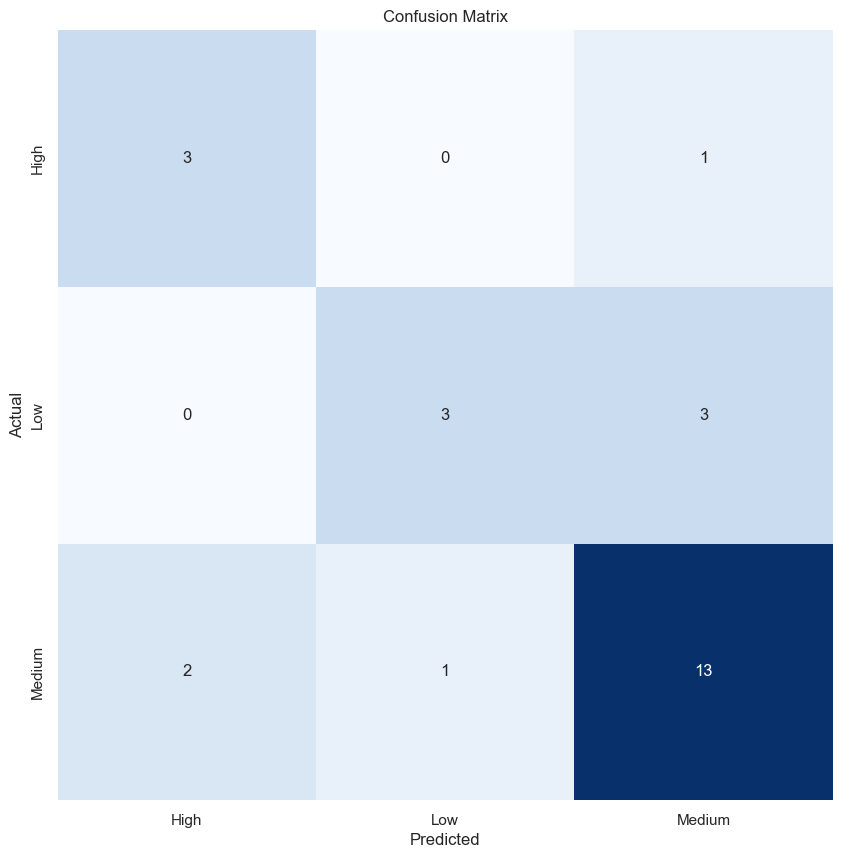

In [519]:
# print the classification report for the best estimator of the gridsearch results
y_pred = grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))
# print confusion matrix with the predicted and actual correct with colors
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')

plt.xlabel('Predicted')
plt.ylabel('Actual')

# put labels on the predicted and actual labels
plt.xticks([0.5,1.5,2.5], ['High', 'Low', 'Medium'])
plt.yticks([0.5,1.5,2.5], ['High', 'Low', 'Medium'])

plt.show()

### Third Model Evaluation
Overall more variance in the cross validation scores, and the accuracy scores are lower so some information is lost when we combine and remove features

## Testing Other Models

In [532]:
# remove morning_traffic and late_traffic from mcd_df_model
mcd_df_model.drop(['morning_traffic','late_traffic'], axis=1, inplace=True)

/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_7630/2216979911.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcd_df_model.drop(['morning_traffic','late_traffic'], axis=1, inplace=True)


/Users/nick/Github/would_you_like_some_fries_with_that/my_functions.py:242: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X.col = list(X.columns)


numerical features used are ['WEEKDAY_7_in_2', 'WEEKDAY_4_out_2', 'sz_income', 'WEEKDAY_22_out_1', 'sz_pop', 'hdb_count1', 'WEEKDAY_7_in_1', 'WEEKDAY_6_in_1', 'WEEKDAY_23_out_1', 'WEEKENDS_HOLIDAY_1_in_2', 'WEEKENDS_HOLIDAY_3_in_2', 'pa_income', 'WEEKENDS_HOLIDAY_23_out_1', 'WEEKENDS_HOLIDAY_0_out_1', 'WEEKENDS_HOLIDAY_2_out_0.5', 'WEEKENDS_HOLIDAY_1_out_2', 'WEEKDAY_6_in_2', 'WEEKDAY_0_out_1', 'WEEKDAY_1_in_1', 'WEEKENDS_HOLIDAY_1_out_1', 'WEEKDAY_1_in_2', 'hdb_count2', 'WEEKDAY_1_out_2', 'hdb_count0.2', 'WEEKENDS_HOLIDAY_22_out_1', 'WEEKENDS_HOLIDAY_8_in_1', 'hdb_count0.5', 'WEEKENDS_HOLIDAY_0_out_0.5']
categorical features used are []

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best training parameters and cross validated accuracy score are:
{'classifier__learning_rate': 0.3, 'classifier__loss': 'log_loss', 'classifier__n_estimators': 100}
the range of scores can be [0.65 0.7  0.6  0.8  0.65]
0.6799999999999999
              precision    recall  f1-score   supp

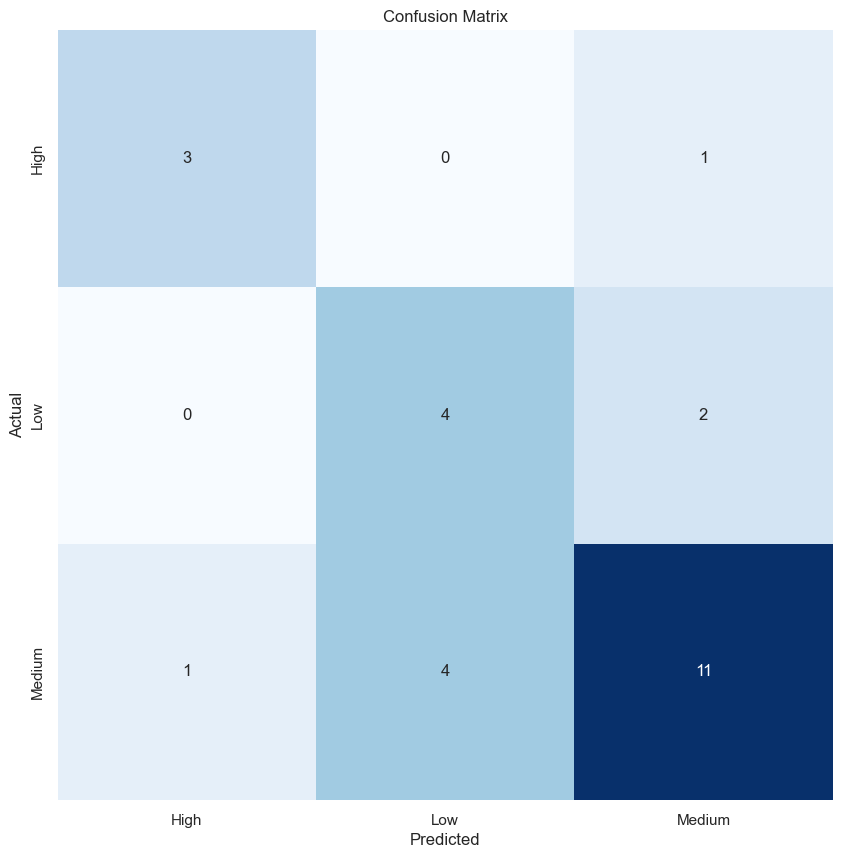

In [564]:
params = {
    'classifier__loss':['log_loss'],
    'classifier__learning_rate':[0.1, 0.2, 0.3, 0.5],
    'classifier__n_estimators':[50, 100, 150],
}

GBC = Model().results(GradientBoostingClassifier(random_state=rs) , mcd_df_model, params, StandardScaler(), OneHotEncoder(), rs, balance='y')

numerical features used are ['WEEKDAY_7_in_2', 'WEEKDAY_4_out_2', 'sz_income', 'WEEKDAY_22_out_1', 'sz_pop', 'hdb_count1', 'WEEKDAY_7_in_1', 'WEEKDAY_6_in_1', 'WEEKDAY_23_out_1', 'WEEKENDS_HOLIDAY_1_in_2', 'WEEKENDS_HOLIDAY_3_in_2', 'pa_income', 'WEEKENDS_HOLIDAY_23_out_1', 'WEEKENDS_HOLIDAY_0_out_1', 'WEEKENDS_HOLIDAY_2_out_0.5', 'WEEKENDS_HOLIDAY_1_out_2', 'WEEKDAY_6_in_2', 'WEEKDAY_0_out_1', 'WEEKDAY_1_in_1', 'WEEKENDS_HOLIDAY_1_out_1', 'WEEKDAY_1_in_2', 'hdb_count2', 'WEEKDAY_1_out_2', 'hdb_count0.2', 'WEEKENDS_HOLIDAY_22_out_1', 'WEEKENDS_HOLIDAY_8_in_1', 'hdb_count0.5', 'WEEKENDS_HOLIDAY_0_out_0.5']
categorical features used are []

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/nick/Github/would_you_like_some_fries_with_that/my_functions.py:242: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X.col = list(X.columns)


The best training parameters and cross validated accuracy score are:
{'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}
the range of scores can be [0.7  0.65 0.55 0.75 0.55]
0.64
              precision    recall  f1-score   support

        High       0.50      1.00      0.67         4
         Low       0.43      0.50      0.46         6
      Medium       0.82      0.56      0.67        16

    accuracy                           0.62        26
   macro avg       0.58      0.69      0.60        26
weighted avg       0.68      0.62      0.62        26

Balanced Accuracy: 0.69



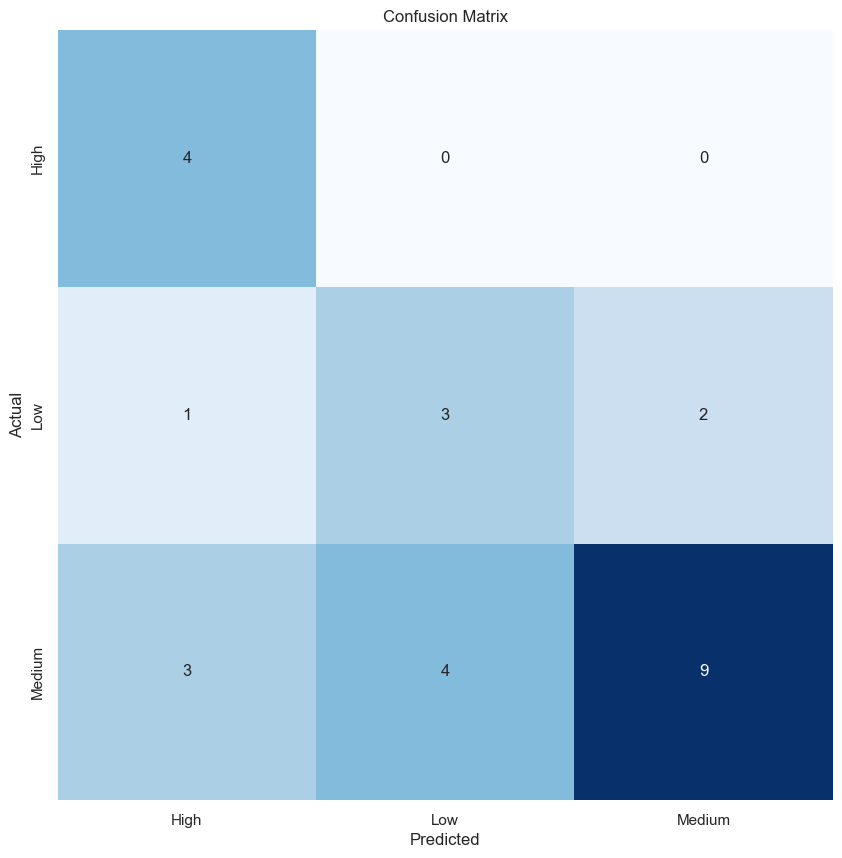

In [565]:
params = {
    'classifier__n_neighbors':[3, 5, 7, 9],
    'classifier__weights':['uniform', 'distance']
}

KNN = Model().results(KNeighborsClassifier() , mcd_df_model, params, StandardScaler(), OneHotEncoder(), rs, balance='y')

numerical features used are ['WEEKDAY_7_in_2', 'WEEKDAY_4_out_2', 'sz_income', 'WEEKDAY_22_out_1', 'sz_pop', 'hdb_count1', 'WEEKDAY_7_in_1', 'WEEKDAY_6_in_1', 'WEEKDAY_23_out_1', 'WEEKENDS_HOLIDAY_1_in_2', 'WEEKENDS_HOLIDAY_3_in_2', 'pa_income', 'WEEKENDS_HOLIDAY_23_out_1', 'WEEKENDS_HOLIDAY_0_out_1', 'WEEKENDS_HOLIDAY_2_out_0.5', 'WEEKENDS_HOLIDAY_1_out_2', 'WEEKDAY_6_in_2', 'WEEKDAY_0_out_1', 'WEEKDAY_1_in_1', 'WEEKENDS_HOLIDAY_1_out_1', 'WEEKDAY_1_in_2', 'hdb_count2', 'WEEKDAY_1_out_2', 'hdb_count0.2', 'WEEKENDS_HOLIDAY_22_out_1', 'WEEKENDS_HOLIDAY_8_in_1', 'hdb_count0.5', 'WEEKENDS_HOLIDAY_0_out_0.5']
categorical features used are []

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/nick/Github/would_you_like_some_fries_with_that/my_functions.py:242: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X.col = list(X.columns)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TO

The best training parameters and cross validated accuracy score are:
{'classifier__C': 2, 'classifier__penalty': 'l2'}
the range of scores can be [0.7  0.7  0.6  0.65 0.6 ]
0.65
              precision    recall  f1-score   support

        High       0.67      1.00      0.80         4
         Low       0.43      0.50      0.46         6
      Medium       0.77      0.62      0.69        16

    accuracy                           0.65        26
   macro avg       0.62      0.71      0.65        26
weighted avg       0.67      0.65      0.65        26

Balanced Accuracy: 0.71



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

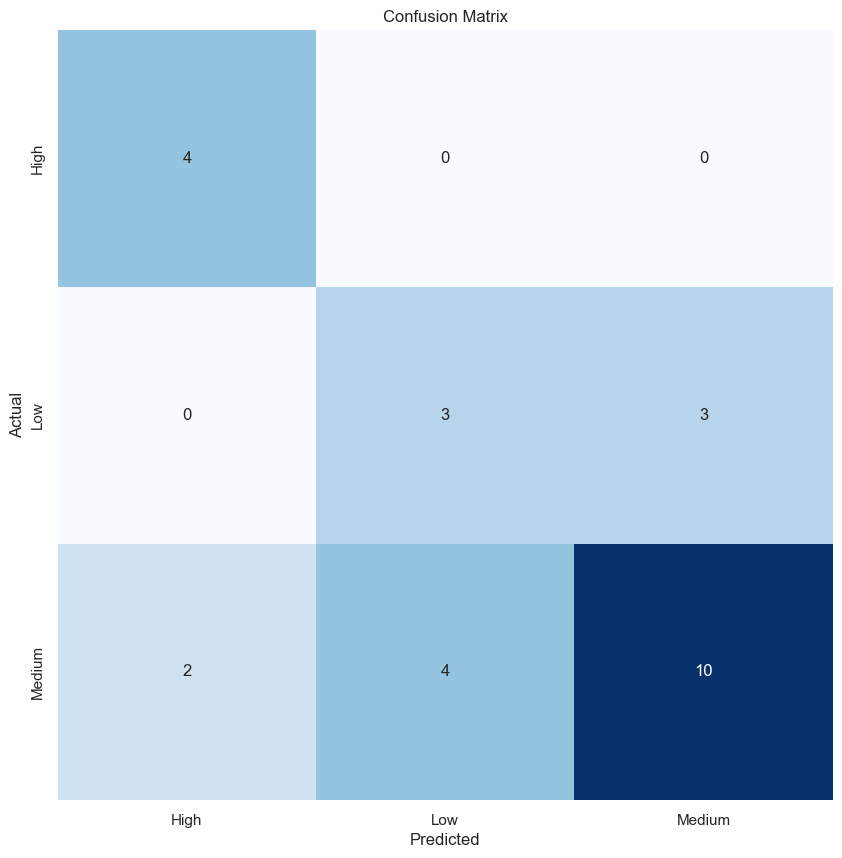

In [566]:
params = {
    'classifier__penalty':['l1','l2'],
    'classifier__C':[0.1, 0.5, 1, 2, 5, 10],
}

LR = Model().results(LogisticRegression(random_state=rs,class_weight='balanced') , mcd_df_model, params, StandardScaler(), OneHotEncoder(), rs)